In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read the data stored after pre-processing stage and analyze to ensure everthing looks fine

In [4]:
book_review_data = pd.read_csv("../data/interim/merged_data_ids.csv")

In [5]:
book_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360666 entries, 0 to 360665
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Title           360666 non-null  object 
 1   description     360666 non-null  object 
 2   authors         358299 non-null  object 
 3   categories      360666 non-null  object 
 4   User_id         360666 non-null  object 
 5   Ratings         360666 non-null  float64
 6   review/summary  360415 non-null  object 
 7   review/text     360666 non-null  object 
 8   UserId          360666 non-null  int64  
 9   BookId          360666 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.5+ MB


In [6]:
book_review_data.sort_values(by = 'UserId').head(10)

Title  \
0                                Dr. Seuss: American Icon   
305077  Artistic License: Three Centuries of Good Writ...   
105601                    Ahab's Wife: Or, the Star-Gazer   
151308                                Heart of the Matter   
269782  OUT OF THE SILENT PLANET - The Perelandra Tril...   
244321                        Who Wrote the Book of Love?   
359042  The Woman Who Walked to Russia: A Writer's Sea...   
40133                                       Silent Spring   
49267   Ogden Nash: The Life and Work of America's Lau...   
270033  New Spring - The Novel - The Wheel Of Time, In...   

                                              description  \
0       Philip Nel takes a fascinating look into the k...   
305077  "Ms. Allen goes on to show how the incendiarie...   
105601  From the opening line—"Captain Ahab was neithe...   
151308  "Giffin excels at creating complex characters ...   
269782  Focuses on the age-old nature and consequences...   
244321  Een eeuwenoude tekst. Een bijzondere historisc...   
359042  From the moment Pybus first heard about Lillia...   
40133   Rachel Carson's Silent Spring alerted a large ...   
49267   Looks at the life, career, and writings of the...   
270033  Moirain Damodred and Lan Mandragoran must find...   

                              authors                      categories  \
0                          Philip Nel  ['Biography', 'Autobiography']   
305077                   Brooke Allen  ['Biography', 'Autobiography']   
105601             Sena Jeter Naslund                     ['Fiction']   
151308                   Emily Giffin                     ['Fiction']   
269782                     C.S. Lewis                     ['Fiction']   
244321              Kathleen MacGowan                     ['Fiction']   
359042                Cassandra Pybus                      ['Travel']   
40133                   Rachel Carson                      ['Nature']   
49267   Douglas M. Parker, Dana Gioia  ['Biography', 'Autobiography']   
270033                  Robert Jordan                     ['Fiction']   

               User_id  Ratings  \
0       A30TK6U7DNS82R      5.0   
305077  A30TK6U7DNS82R      3.0   
105601  A30TK6U7DNS82R      3.0   
151308  A30TK6U7DNS82R      4.0   
269782  A30TK6U7DNS82R      5.0   
244321  A30TK6U7DNS82R      3.0   
359042  A30TK6U7DNS82R      3.0   
40133   A30TK6U7DNS82R      5.0   
49267   A30TK6U7DNS82R      5.0   
270033  A30TK6U7DNS82R      4.0   

                                           review/summary  \
0                                       really enjoyed it   
305077                  the dentists office of literature   
105601                   a good romance for the homebound   
151308      a matter of fact book that might save my life   
269782  should have been filmed instead of the narnia ...   
244321                                 chuckles about sex   
359042                                          easypeasy   
40133                                     another thoreau   
49267                                           nashville   
270033                        missing    one kitchen sink   

                                              review/text  UserId  BookId  
0       i dont care much for dr seuss but after readin...       0       0  
305077  i hate these thrown together collections of es...       0   55023  
105601  if you are a shutin who likes to keep one eye ...       0   15312  
151308  i was lucky to stumble across an advance readi...       0   23995  
269782  it seems as though the success of the lord of ...       0   47659  
244321  lee siegels novel of a group of sex obsessed b...       0   41974  
359042  cassandra pybus an australian writer heard abo...       0   66821  
40133   rachel carson wrote so beautifully that any fe...       0    5686  
49267   loved the book ogden nash not so much as a lit...       0    7233  
270033  otherwise a new spring has everything that a r...       0   47695

In [7]:
book_review_data.sort_values(by="BookId").head(10)

Title  \
0                            Dr. Seuss: American Icon   
1                            Dr. Seuss: American Icon   
2                            Dr. Seuss: American Icon   
3               Wonderful Worship in Smaller Churches   
4   Rising Sons and Daughters: Life Among Japan's ...   
5   Muslim Women's Choices: Religious Belief and S...   
6                         Dramatica for Screenwriters   
7   Vector Quantization and Signal Compression (Th...   
10                  Eyewitness Travel Guide to Europe   
8                   Eyewitness Travel Guide to Europe   

                                          description  \
0   Philip Nel takes a fascinating look into the k...   
1   Philip Nel takes a fascinating look into the k...   
2   Philip Nel takes a fascinating look into the k...   
3   This resource includes twelve principles in un...   
4   Wardell recalls his experience as a foreign st...   
5   Counters the Western views and stereotypes of ...   
6   Dramatica for Screenwriters by Armando Saldana...   
7   Herb Caen, a popular columnist for the San Fra...   
10  The DK Eyewitness Travel Guide: Eastern and Ce...   
8   The DK Eyewitness Travel Guide: Eastern and Ce...   

                                              authors  \
0                                          Philip Nel   
1                                          Philip Nel   
2                                          Philip Nel   
3                                        David R. Ray   
4                                      Steven Wardell   
5                  Camillia Fawzi El-Solh, Judy Mabro   
6                                Armando Salda A-Mora   
7                        Allen Gersho, Robert M. Gray   
10  Dorling Kindersley Publishing Staff, Jonathan ...   
8   Dorling Kindersley Publishing Staff, Jonathan ...   

                        categories         User_id  Ratings  \
0   ['Biography', 'Autobiography']  A30TK6U7DNS82R      5.0   
1   ['Biography', 'Autobiography']  A2MVUWT453QH61      4.0   
2   ['Biography', 'Autobiography']  A2F6NONFUDB6UK      4.0   
3                     ['Religion']  A373VVEU6Z9M0N      5.0   
4               ['Social Science']  A3NIQK6ZLYEP1L      4.0   
5                     ['Religion']   ATDE9JYCPI0L1      2.0   
6                    ['Reference']  A32ZQ5DEXBL60Z      5.0   
7    ['Technology', 'Engineering']   A29Z0B2L367ZO      5.0   
10                      ['Europe']   AT9YSY20RJUDX      4.0   
8                       ['Europe']  A281NPSIMI1C2R      5.0   

                                       review/summary  \
0                                   really enjoyed it   
1     phlip nel gives silly seuss a serious treatment   
2           one of americas greatest creative talents   
3           small churches can have wonderful worship   
4                            almost a day by day view   
5                                             oh dear   
6   even as a fiction writer i found this book inv...   
7                  great reference book for its topic   
10              helpful guide on tours through europe   
8       the major sights in twenty countries  amazing   

                                          review/text  UserId  BookId  
0   i dont care much for dr seuss but after readin...       0       0  
1   theodore seuss geisel 19041991 aka quotdr seus...       1       0  
2   dr seuss american icon by philip nel is a thou...       2       0  
3   many small churches feel like they can not hav...       3       1  
4   steven wardell went to japan without reading a...       4       2  
5   i was excited to find a book ostensibly about ...       5       3  
6   i think the hardest thing for people coming to...       6       4  
7   it seems somebody was complaining for the prin...       7       5  
10  i recently took a backpack trip through europe...      10       6  
8   yes this is one heavy book it is more than lik...       8       6

### We will start building the collaborative filtering model

In [8]:
X = book_review_data[['UserId', 'BookId']]
y = book_review_data[['Ratings']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = .25, random_state = 0, stratify = book_review_data.Ratings.values)

### We will use PyTorch to build our collaborative filtering model. The first step in build a PyTorch model is to define the dataset

In [9]:
class BookReviewDataset(Dataset):
    def __init__(self, users, books, ratings):
        self.users = users
        self.books = books
        self.ratings = ratings
    
    # length will be all the reviews, which we can get using length of users
    def __len__(self):
        return len(self.users)
     
    def __getitem__(self, idx):

        users = self.users[idx] 
        books = self.books[idx]
        ratings = self.ratings[idx]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "books": torch.tensor(books, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [10]:
train_dataset = BookReviewDataset(
    users=X_train.UserId.values,
    books=X_train.BookId.values,
    ratings=y_train.Ratings.values
)

valid_dataset = BookReviewDataset(
    users=X_test.UserId.values,
    books=X_test.BookId.values,
    ratings=y_test.Ratings.values
)

### We will now build DataLoaders and do a manual iteration to check if it works fine

In [11]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True) 

dataiter = iter(train_loader)
dataloader_data = next(dataiter) 
print(dataloader_data)

{'users': tensor([14583, 12710,   302, 14527]), 'books': tensor([43948, 19552, 23974, 22738]), 'ratings': tensor([4, 3, 5, 5])}


In [12]:
class BookRecModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors = 50, y_range=(0,5.5)):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embeds = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_embeds = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.y_range = y_range
        
    def forward(self, users, books, ratings=None):
        user_factors = self.user_embeds(users)
        book_factors = self.book_embeds(books)
        res = (user_factors * book_factors).sum(dim = 1, keepdim = True)
        res += self.user_bias (users) + self.book_bias(books)
        return torch.sigmoid(res) * 5.5

In [13]:
unique_users = X.UserId.unique().shape[0]
unique_books = X.BookId.unique().shape[0]
print (unique_users, unique_books)

21147 67192


### Here set the optimizer, learning rate and weight decay. It took a few iterations to find the most optimal values

In [14]:
model = BookRecModel (n_users = unique_users, n_books = unique_books).to(device)
optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.5) #torch.optim.Adam(model.parameters(), weight_decay=0.1)  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_func = nn.MSELoss()

In [15]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    step_cnt = 0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["books"].to(device)
                      ) 
        
        rating = train_data["ratings"].view(output.size()[0], -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss


epoch 0 loss at step: 5000 is 0.24357187252789736
epoch 0 loss at step: 10000 is 0.2020240258064121
epoch 0 loss at step: 15000 is 0.19991906626448036
epoch 0 loss at step: 20000 is 0.199828506334126
epoch 0 loss at step: 25000 is 0.2021632206186652
epoch 0 loss at step: 30000 is 0.20141556344479322
epoch 0 loss at step: 35000 is 0.2010456224180758
epoch 0 loss at step: 40000 is 0.1998388542741537
epoch 0 loss at step: 45000 is 0.20180967107862235
epoch 0 loss at step: 50000 is 0.2005848926976323
epoch 0 loss at step: 55000 is 0.20007767412513494
epoch 0 loss at step: 60000 is 0.19878186824377625
epoch 0 loss at step: 65000 is 0.20334235767796635
epoch 0 loss at step: 70000 is 0.20246565698087216
epoch 0 loss at step: 75000 is 0.2019658163074404
epoch 0 loss at step: 80000 is 0.20120332323610782
epoch 0 loss at step: 85000 is 0.20098521508425474
epoch 0 loss at step: 90000 is 0.19976731309443713
epoch 0 loss at step: 95000 is 0.20290634814724326
epoch 0 loss at step: 100000 is 0.199444

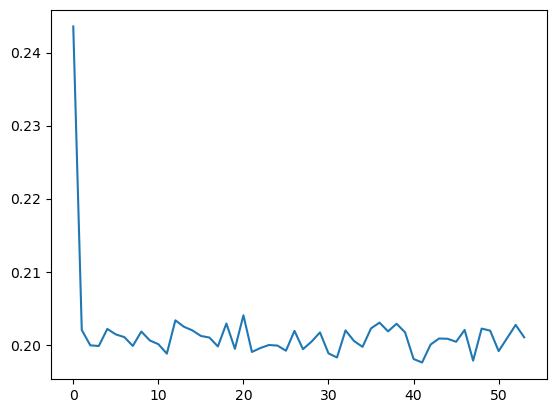

In [16]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Let's now evaluate the model using validation (test in this case) dataset. We will first evaluate using confusion matrix and then RMSE

### The model's output is currently continuous and we need to change it to discreet values. Below is a function that does that. The range to convert continuous output to a rating is based on the observations from previous training of the model

In [17]:
model.eval()
y_pred = []
y_actual = []    
    
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["books"].to(device))
        
        # Convert model ouput to numpy array
        numparray = model_output.squeeze().detach().cpu().numpy()
        y_pred.extend(numparray)
        y_actual.extend(batched_data['ratings'].detach().cpu().numpy().tolist())
        print (f"Model output {model_output} actual ratings {batched_data['ratings']}" )



Model output tensor([[2.7662],
        [2.7539],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7576],
        [2.7500],
        [2.7500],
        [2.7563]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7506],
        [2.7760],
        [2.7500],
        [2.7535]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.8098],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 4, 4])
Model output tensor([[2.7456],
        [2.7691],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 2, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7884],
        [2.7627],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.760

Model output tensor([[2.7675],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7574],
        [2.7520],
        [2.7619]], device='cuda:0') actual ratings tensor([4, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7558],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7497],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7502],
        [2.7501],
        [2.7683],
        [2.7562]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7516],
        [2.7505],
        [2.7532],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.747

Model output tensor([[2.7541],
        [2.7495],
        [2.7808],
        [2.7715]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7534],
        [2.7508],
        [2.7589],
        [2.7608]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7585],
        [2.7596]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7514],
        [2.7510],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7354],
        [2.7500],
        [2.7500],
        [2.7690]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7553],
        [2.7517],
        [2.7519],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 4, 1])
Model output tensor([[2.7508],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7634],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7604],
        [2.7500],
        [2.7574]], device='cuda:0') actual ratings tensor([3, 1, 4, 4])
Model output tensor([[2.7625],
        [2.7511],
        [2.7569],
        [2.7507]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7596],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7548],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7478]], device='cuda:0') actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.7631],
        [2.7589],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7501],
        [2.7618],
        [2.7676]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7570],
        [2.7561],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.8094],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([3, 4, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7543]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7954],
        [2.7539],
        [2.7525],
        [2.7767]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7513],
        [2.7716],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7501],
        [2.7518],
        [2.7503],
        [2.7528]], device='cuda:0') actual ratings tensor([2, 2, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7551]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7637],
        [2.7500],
        [2.7659],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7567],
        [2.7500],
        [2.7500],
        [2.7693]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7569]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7511],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7551],
        [2.7659],
        [2.7563],
        [2.7529]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7470],
        [2.7544],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7502],
        [2.7773],
        [2.7578],
        [2.7715]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7548],
        [2.7516],
        [2.7516],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7563],
        [2.7526],
        [2.7602],
        [2.8085]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7504],
        [2.7746],
        [2.7500],
        [2.7600]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7536],
        [2.7523],
        [2.7517]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7592],
        [2.7500],
        [2.7532]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7502],
        [2.7555]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7523],
        [2.7500],
        [2.7535],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7656],
        [2.7500],
        [2.7500],
        [2.7659]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7528],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7502],
        [2.7501],
        [2.7500],
        [2.7771]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7567],
        [2.7513],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7531],
        [2.7500],
        [2.7500],
        [2.7590]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7559],
        [2.7508],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 3, 2, 3])
Model output tensor([[2.759

Model output tensor([[2.7660],
        [2.7513],
        [2.7654],
        [2.7661]], device='cuda:0') actual ratings tensor([5, 4, 2, 2])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7514],
        [2.7685],
        [2.7546],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7506],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7675],
        [2.7500],
        [2.8098],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7712],
        [2.7714],
        [2.7715]], device='cuda:0') actual ratings tensor([2, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7532],
        [2.7500],
        [2.7455]], device='cuda:0') actual ratings tensor([5, 3, 2, 2])
Model output tensor([[2.751

Model output tensor([[2.7507],
        [2.7500],
        [2.7520],
        [2.7585]], device='cuda:0') actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7476],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7544],
        [2.7506],
        [2.7500],
        [2.7594]], device='cuda:0') actual ratings tensor([5, 4, 3, 2])
Model output tensor([[2.7500],
        [2.7619],
        [2.7593],
        [2.8094]], device='cuda:0') actual ratings tensor([3, 5, 2, 4])
Model output tensor([[2.7498],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.764

Model output tensor([[2.7500],
        [2.7635],
        [2.7841],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 1, 3])
Model output tensor([[2.7512],
        [2.7500],
        [2.7509],
        [2.7509]], device='cuda:0') actual ratings tensor([2, 3, 5, 2])
Model output tensor([[2.7512],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7588],
        [2.7500],
        [2.7494]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7511],
        [2.7550],
        [2.7519]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7583]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7528],
        [2.7526],
        [2.7525],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.767

Model output tensor([[2.7501],
        [2.7469],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7589],
        [2.7685],
        [2.8086],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7507],
        [2.7500],
        [2.7950]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7595],
        [2.7841],
        [2.7511],
        [2.7772]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7507],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7439],
        [2.7500],
        [2.7510],
        [2.7366]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.770

Model output tensor([[2.7500],
        [2.7538],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7510],
        [2.7538],
        [2.7504],
        [2.7455]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.8085],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7427],
        [2.7502],
        [2.7528],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7634],
        [2.7505],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.7508],
        [2.7500],
        [2.7695],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.752

Model output tensor([[2.7564],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 4])
Model output tensor([[2.7590],
        [2.7506],
        [2.7570],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7556],
        [2.7500],
        [2.7543],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7559],
        [2.7480],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7503],
        [2.7656],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.7597],
        [2.7516],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7576],
        [2.7618],
        [2.7519]], device='cuda:0') actual ratings tensor([5, 3, 3, 2])
Model output tensor([[2.750

Model output tensor([[2.7504],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7523],
        [2.7501],
        [2.7577],
        [2.7560]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7497],
        [2.7500],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7612],
        [2.7500],
        [2.7501],
        [2.7516]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7505],
        [2.7521]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7523],
        [2.7500],
        [2.8079],
        [2.7495]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7635],
        [2.7633],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7554],
        [2.7521],
        [2.7659],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7554],
        [2.7688],
        [2.7501],
        [2.7530]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7721],
        [2.7921],
        [2.7474],
        [2.7629]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7531],
        [2.7506],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7559],
        [2.7688],
        [2.7690]], device='cuda:0') actual ratings tensor([3, 5, 2, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7532],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7616],
        [2.7622],
        [2.8098]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.758

Model output tensor([[2.7511],
        [2.7670],
        [2.7500],
        [2.7545]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7599],
        [2.7515],
        [2.7644]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7567],
        [2.7394],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7767],
        [2.7517]], device='cuda:0') actual ratings tensor([1, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7861],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 2, 5])
Model output tensor([[2.7500],
        [2.7722],
        [2.7500],
        [2.7519]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7642],
        [2.7500],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.8094],
        [2.7467],
        [2.7591],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7529],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7592],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7515],
        [2.7501],
        [2.7541]], device='cuda:0') actual ratings tensor([3, 5, 5, 1])
Model output tensor([[2.7618],
        [2.7500],
        [2.7567],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 3])
Model output tensor([[2.7607],
        [2.7761],
        [2.7512],
        [2.7495]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7523],
        [2.7507],
        [2.7537]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.755

Model output tensor([[2.7912],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7520],
        [2.7500],
        [2.7500],
        [2.7638]], device='cuda:0') actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7500],
        [2.7611],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7687],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7671],
        [2.7707]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7504],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7714],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.752

Model output tensor([[2.7565],
        [2.7514],
        [2.7515],
        [2.7679]], device='cuda:0') actual ratings tensor([3, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7558],
        [2.7500],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7558],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 5, 2, 1])
Model output tensor([[2.7500],
        [2.7681],
        [2.7500],
        [2.7636]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7522],
        [2.7500],
        [2.7530],
        [2.7518]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7510],
        [2.7514]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7558],
        [2.7500],
        [2.7529],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.751

Model output tensor([[2.7515],
        [2.7514],
        [2.7521],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7585],
        [2.7571],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7529],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 1])
Model output tensor([[2.7671],
        [2.8085],
        [2.7506],
        [2.7695]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7599],
        [2.7609],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 1])
Model output tensor([[2.7611],
        [2.7501],
        [2.7650],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7399],
        [2.8098],
        [2.7660]], device='cuda:0') actual ratings tensor([2, 4, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7633],
        [2.8094]], device='cuda:0') actual ratings tensor([5, 4, 5, 1])
Model output tensor([[2.7525],
        [2.7500],
        [2.7487],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7954],
        [2.7505],
        [2.7521],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7508],
        [2.7511],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 3, 2])
Model output tensor([[2.7504],
        [2.7523],
        [2.7487],
        [2.7662]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7610],
        [2.7513],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7890],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7558],
        [2.7500],
        [2.7614]], device='cuda:0') actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7617],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 1, 3, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7553],
        [2.7672]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7659],
        [2.7502],
        [2.7707],
        [2.7552]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7515],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 5, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.8098],
        [2.7678]], device='cuda:0') actual ratings tensor([4, 4, 3, 2])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7575]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7539]], device='cuda:0') actual ratings tensor([4, 4, 1, 4])
Model output tensor([[2.7543],
        [2.7500],
        [2.7526],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7904],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7691],
        [2.7639],
        [2.7633],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.752

Model output tensor([[2.7500],
        [2.7531],
        [2.7510],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7724],
        [2.7514],
        [2.7542],
        [2.7508]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7670],
        [2.7664]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7509],
        [2.7764],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7861],
        [2.7513],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7508],
        [2.7596]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7593],
        [2.7586],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 2, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7534]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7690],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7861],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.8098],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 3, 5, 4])
Model output tensor([[2.7662],
        [2.7551],
        [2.7500],
        [2.7658]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7592],
        [2.7500],
        [2.7627],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7509],
        [2.7500],
        [2.7500],
        [2.7599]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.808

Model output tensor([[2.7501],
        [2.7511],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7642],
        [2.7625],
        [2.7690],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7613],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7573],
        [2.7530],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7712],
        [2.7585],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7522],
        [2.7462],
        [2.7498],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7640],
        [2.7671],
        [2.7526],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7575],
        [2.7579],
        [2.7671],
        [2.7961]], device='cuda:0') actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7501],
        [2.7599],
        [2.7500],
        [2.7526]], device='cuda:0') actual ratings tensor([4, 2, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7633]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7511],
        [2.7501],
        [2.7596],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7490],
        [2.7500],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7543]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.750

Model output tensor([[2.7576],
        [2.7505],
        [2.7497],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7529],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7605],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 3, 5, 3])
Model output tensor([[2.7588],
        [2.7501],
        [2.7596],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7546],
        [2.7502],
        [2.7529]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.784

Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7574]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7605],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 1, 4, 3])
Model output tensor([[2.7500],
        [2.8083],
        [2.7520],
        [2.7567]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7504],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7501],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7877],
        [2.7574],
        [2.7635]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.769

Model output tensor([[2.7656],
        [2.7501],
        [2.7518],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.7715],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7507],
        [2.7950],
        [2.7504],
        [2.7512]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7511],
        [2.7520],
        [2.7500],
        [2.7519]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7509],
        [2.7469],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 2, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7591],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7511],
        [2.7494],
        [2.7500],
        [2.7688]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7511],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7875],
        [2.7525],
        [2.7691],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7538],
        [2.7688],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7511],
        [2.7609]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7577],
        [2.7734],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.760

Model output tensor([[2.7764],
        [2.7500],
        [2.7499],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7522],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7503],
        [2.7507],
        [2.7577],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7505],
        [2.7500],
        [2.7538]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7593],
        [2.7555],
        [2.7502],
        [2.7545]], device='cuda:0') actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.7501],
        [2.7657],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7596],
        [2.7501],
        [2.7504]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7641],
        [2.7500],
        [2.7583],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7495],
        [2.7500],
        [2.7565]], device='cuda:0') actual ratings tensor([5, 4, 5, 1])
Model output tensor([[2.7500],
        [2.7529],
        [2.7505],
        [2.7779]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7554],
        [2.7500],
        [2.7637]], device='cuda:0') actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7509],
        [2.7500],
        [2.7634]], device='cuda:0') actual ratings tensor([3, 1, 3, 3])
Model output tensor([[2.7626],
        [2.7500],
        [2.7521],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 1, 4])
Model output tensor([[2.7842],
        [2.7611],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.752

Model output tensor([[2.7503],
        [2.7503],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([1, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7530],
        [2.7528],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7500],
        [2.7688],
        [2.7517],
        [2.7515]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7517],
        [2.7807],
        [2.7505],
        [2.7625]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7957]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.755

Model output tensor([[2.7580],
        [2.7504],
        [2.7500],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7562],
        [2.7521],
        [2.7718],
        [2.7555]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7764],
        [2.7563],
        [2.7509],
        [2.7593]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7693],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7593],
        [2.7502],
        [2.7717],
        [2.7558]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7522],
        [2.7500],
        [2.7808],
        [2.7583]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7729],
        [2.7665],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7766]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7558],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7513],
        [2.7500],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7600],
        [2.7516],
        [2.7635],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7513],
        [2.7511],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7503],
        [2.7982],
        [2.7505],
        [2.7515]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7537],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 4, 1])
Model output tensor([[2.750

Model output tensor([[2.7509],
        [2.7502],
        [2.7690],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7733],
        [2.7500],
        [2.7520],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7712],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7514],
        [2.7665],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7650],
        [2.7500],
        [2.7642],
        [2.7734]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.8098],
        [2.7683],
        [2.7506],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7505],
        [2.7534],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7609],
        [2.7608],
        [2.7513],
        [2.7592]], device='cuda:0') actual ratings tensor([3, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7515],
        [2.7525],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7528],
        [2.7500],
        [2.7472],
        [2.7683]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7423]], device='cuda:0') actual ratings tensor([5, 3, 2, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7611],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7534]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7511],
        [2.7500],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7525],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7503],
        [2.7500],
        [2.7750],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7534],
        [2.7495],
        [2.7500],
        [2.7533]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7511],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.8098],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7554],
        [2.7508],
        [2.7592]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7486],
        [2.7539],
        [2.7516]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7950],
        [2.7989],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7504],
        [2.7574],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7523],
        [2.7481],
        [2.7642]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7612],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 3, 4])
Model output tensor([[2.7512],
        [2.7498],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.754

Model output tensor([[2.7500],
        [2.7505],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7706]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7523],
        [2.7502],
        [2.7500],
        [2.7689]], device='cuda:0') actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7505],
        [2.7504],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.7539],
        [2.7501],
        [2.8094],
        [2.7518]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 3, 5, 2])
Model output tensor([[2.760

Model output tensor([[2.7500],
        [2.7577],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7530],
        [2.7501],
        [2.7500],
        [2.7602]], device='cuda:0') actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7505],
        [2.7500],
        [2.7535],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7694],
        [2.7504],
        [2.7670],
        [2.7645]], device='cuda:0') actual ratings tensor([3, 5, 1, 5])
Model output tensor([[2.7510],
        [2.7693],
        [2.7616],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 3])
Model output tensor([[2.7500],
        [2.7737],
        [2.7503],
        [2.7909]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7921],
        [2.7500],
        [2.7500],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.756

Model output tensor([[2.7890],
        [2.7500],
        [2.7494],
        [2.7622]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7602],
        [2.7529],
        [2.7561]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7625],
        [2.7506],
        [2.7516],
        [2.7553]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7687],
        [2.7500],
        [2.7500],
        [2.7520]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7572],
        [2.7500],
        [2.7500],
        [2.7659]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7522],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7371],
        [2.7842],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7657],
        [2.7507],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7569],
        [2.7781],
        [2.7667],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.7502],
        [2.7646],
        [2.7948],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7664],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7514],
        [2.7500],
        [2.7546]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7517],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.753

Model output tensor([[2.7511],
        [2.7501],
        [2.7658],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7554],
        [2.7500],
        [2.7501],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7675],
        [2.7507],
        [2.7500],
        [2.7660]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7526],
        [2.7500],
        [2.7501],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7537],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.8079],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7544],
        [2.7524],
        [2.7425],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.756

Model output tensor([[2.7659],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7539],
        [2.7723],
        [2.7505],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7516],
        [2.7507],
        [2.7500],
        [2.7531]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7841],
        [2.7500],
        [2.7503],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7528],
        [2.7500],
        [2.7904],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7827],
        [2.7524],
        [2.7516],
        [2.7514]], device='cuda:0') actual ratings tensor([4, 4, 2, 3])
Model output tensor([[2.7506],
        [2.7500],
        [2.7618],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7575],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7516],
        [2.7500],
        [2.7533],
        [2.7498]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7510],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 1, 5, 4])
Model output tensor([[2.7559],
        [2.7500],
        [2.7503],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7507],
        [2.7500],
        [2.7500],
        [2.7532]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7651],
        [2.7550],
        [2.7689],
        [2.7540]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7524],
        [2.7797],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7516],
        [2.7597],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7583],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7692],
        [2.7587],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.7503],
        [2.7500],
        [2.7558],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7523],
        [2.7500],
        [2.7581],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7455],
        [2.7500],
        [2.7801],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 3, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7564]], device='cuda:0') actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7562],
        [2.7502],
        [2.7542],
        [2.7516]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7841],
        [2.7536],
        [2.7814],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.8098],
        [2.7538],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7511],
        [2.7687],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7609],
        [2.7507],
        [2.7500],
        [2.8098]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7625],
        [2.7546],
        [2.7501],
        [2.7485]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7851],
        [2.7519],
        [2.7501],
        [2.7539]], device='cuda:0') actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7505],
        [2.7517],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7634]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7594],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7761],
        [2.7585],
        [2.7708],
        [2.7507]], device='cuda:0') actual ratings tensor([2, 5, 4, 1])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7717]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.752

Model output tensor([[2.7500],
        [2.7606],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7522],
        [2.7684],
        [2.7625]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7506],
        [2.7506],
        [2.7543],
        [2.7499]], device='cuda:0') actual ratings tensor([1, 4, 5, 3])
Model output tensor([[2.7510],
        [2.7502],
        [2.7612],
        [2.7786]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7541]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7595],
        [2.7712],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.749

Model output tensor([[2.7599],
        [2.7691],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7561]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7520],
        [2.7577],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7570],
        [2.7502],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7582],
        [2.7443],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7504],
        [2.7511],
        [2.7500],
        [2.7582]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7519],
        [2.7532],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.752

Model output tensor([[2.7583],
        [2.7500],
        [2.7670],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7676],
        [2.7502],
        [2.7692]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7659],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7549],
        [2.7600],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7571],
        [2.7506],
        [2.7503],
        [2.7565]], device='cuda:0') actual ratings tensor([4, 3, 3, 4])
Model output tensor([[2.7610],
        [2.7502],
        [2.8079],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8098],
        [2.7568],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7540],
        [2.7500],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7954],
        [2.7614],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7591],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.8098],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7542],
        [2.7814],
        [2.7646],
        [2.7547]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7539],
        [2.7521],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7627],
        [2.7536],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7481],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7522],
        [2.7499]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7542],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7548],
        [2.7687],
        [2.7748],
        [2.7536]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.752

Model output tensor([[2.7500],
        [2.7521],
        [2.7532],
        [2.7575]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7683],
        [2.7500],
        [2.7570],
        [2.7443]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7498],
        [2.7619],
        [2.7503],
        [2.7498]], device='cuda:0') actual ratings tensor([3, 3, 5, 2])
Model output tensor([[2.7573],
        [2.7502],
        [2.7732],
        [2.7530]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7591],
        [2.7500],
        [2.7614],
        [2.7572]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7591]], device='cuda:0') actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7563],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7439],
        [2.7515],
        [2.7500],
        [2.7589]], device='cuda:0') actual ratings tensor([2, 1, 5, 5])
Model output tensor([[2.7638],
        [2.7512],
        [2.7594],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7521],
        [2.7869]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7519],
        [2.7874],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7413],
        [2.7500],
        [2.7670]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7437],
        [2.7618],
        [2.7679]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7649],
        [2.7513],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7509],
        [2.7500],
        [2.7707],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7614],
        [2.7500],
        [2.7500],
        [2.7678]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7506],
        [2.7509],
        [2.7535],
        [2.7497]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7472],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7697],
        [2.7505],
        [2.7634],
        [2.7737]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7597],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.765

Model output tensor([[2.7500],
        [2.7550],
        [2.7507],
        [2.7734]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7797],
        [2.7650],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7954],
        [2.7573],
        [2.7558]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7665],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7525],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 4, 1, 4])
Model output tensor([[2.7495],
        [2.7500],
        [2.7445],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7512],
        [2.7838],
        [2.7558],
        [2.7706]], device='cuda:0') actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7511],
        [2.7505],
        [2.7539]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7521],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7568],
        [2.7500],
        [2.8079],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7513],
        [2.7656],
        [2.7516],
        [2.7678]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7570],
        [2.7500],
        [2.7670]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7630],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7597],
        [2.7500],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.777

Model output tensor([[2.7497],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([2, 4, 2, 2])
Model output tensor([[2.7704],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7486],
        [2.7555]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7523],
        [2.7500],
        [2.7516],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 1, 1])
Model output tensor([[2.7500],
        [2.7542],
        [2.7500],
        [2.7585]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7641],
        [2.7599],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7691],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7535],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7536],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7712],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7739],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7694],
        [2.7598],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7686],
        [2.7543],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7573],
        [2.7500],
        [2.7861]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.735

Model output tensor([[2.7506],
        [2.7694],
        [2.7500],
        [2.7487]], device='cuda:0') actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 4, 3, 1])
Model output tensor([[2.7502],
        [2.7500],
        [2.7737],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7687],
        [2.7500],
        [2.7640],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7543],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7505],
        [2.7501],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7670],
        [2.7500],
        [2.7639],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.773

Model output tensor([[2.7510],
        [2.7539],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7602],
        [2.7500],
        [2.7500],
        [2.7687]], device='cuda:0') actual ratings tensor([2, 4, 3, 5])
Model output tensor([[2.7613],
        [2.7500],
        [2.7515],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7560],
        [2.7500],
        [2.7500],
        [2.7560]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7524],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7502],
        [2.7500],
        [2.7505],
        [2.7532]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7626],
        [2.7664],
        [2.7501],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.8098],
        [2.7622],
        [2.7506],
        [2.7961]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7596]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7513]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7532],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 1, 3])
Model output tensor([[2.7493],
        [2.7507],
        [2.7769],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7501],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 3, 3, 2])
Model output tensor([[2.7538],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7764],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7537],
        [2.7661],
        [2.7513],
        [2.7524]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7585],
        [2.7392],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7501],
        [2.7505],
        [2.7504],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7567]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7583],
        [2.7500],
        [2.7501],
        [2.7577]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7704],
        [2.7704]], device='cuda:0') actual ratings tensor([5, 2, 5, 3])
Model output tensor([[2.760

Model output tensor([[2.7549],
        [2.7500],
        [2.7500],
        [2.7630]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7671],
        [2.7570],
        [2.7607],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7527]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7555],
        [2.7527],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7532],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7464],
        [2.7634],
        [2.7485],
        [2.7509]], device='cuda:0') actual ratings tensor([2, 5, 3, 5])
Model output tensor([[2.7507],
        [2.7509],
        [2.7518],
        [2.7488]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7582],
        [2.7585]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7580],
        [2.7504],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7503],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7518],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7520]], device='cuda:0') actual ratings tensor([4, 5, 1, 4])
Model output tensor([[2.764

Model output tensor([[2.7622],
        [2.7500],
        [2.7698],
        [2.7412]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7520],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7715],
        [2.7630],
        [2.7503],
        [2.7689]], device='cuda:0') actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.7537],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7743],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 4])
Model output tensor([[2.7511],
        [2.7500],
        [2.7543],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7503],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7642],
        [2.7500],
        [2.7500],
        [2.7524]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7602],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([4, 5, 3, 2])
Model output tensor([[2.7552],
        [2.7503],
        [2.7687],
        [2.7525]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7605],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 1])
Model output tensor([[2.7496],
        [2.7623],
        [2.7500],
        [2.7540]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7621],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.758

Model output tensor([[2.7500],
        [2.7500],
        [2.8079],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7603],
        [2.7500],
        [2.7510],
        [2.7650]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7797],
        [2.7500],
        [2.7508]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7525],
        [2.7985],
        [2.7500],
        [2.7734]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7619],
        [2.7518],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7526],
        [2.7705],
        [2.7499]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7884],
        [2.7573],
        [2.7502],
        [2.7626]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7513],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7520],
        [2.7541],
        [2.7553],
        [2.7536]], device='cuda:0') actual ratings tensor([2, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7583]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7746],
        [2.7532],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 1])
Model output tensor([[2.7500],
        [2.7954],
        [2.7509],
        [2.7686]], device='cuda:0') actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7544],
        [2.7499],
        [2.7500],
        [2.7544]], device='cuda:0') actual ratings tensor([4, 1, 2, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7737],
        [2.7683],
        [2.7504],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7568],
        [2.7656],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7694],
        [2.7500],
        [2.7504],
        [2.7525]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7670],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7610],
        [2.7587]], device='cuda:0') actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.753

Model output tensor([[2.7502],
        [2.7500],
        [2.7502],
        [2.7423]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7705],
        [2.7496],
        [2.7520],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7530],
        [2.7598],
        [2.7508]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.7508],
        [2.7550]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 4, 3])
Model output tensor([[2.7512],
        [2.7508],
        [2.7690],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7529],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.777

Model output tensor([[2.7729],
        [2.7468],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7744],
        [2.7609],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7615],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7954],
        [2.7500],
        [2.7769],
        [2.7837]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7561],
        [2.7500],
        [2.7634],
        [2.7452]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7498],
        [2.8160]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7532],
        [2.7527]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7412],
        [2.7732],
        [2.7690],
        [2.7714]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8094],
        [2.7519],
        [2.7571],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7555],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7637],
        [2.7867]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7590],
        [2.7505],
        [2.7719],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 1, 4])
Model output tensor([[2.7656],
        [2.7582],
        [2.7525],
        [2.7803]], device='cuda:0') actual ratings tensor([5, 4, 4, 1])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7524],
        [2.7611],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7555],
        [2.7722],
        [2.7797]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7509],
        [2.7585],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 1, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7673],
        [2.7915],
        [2.7528],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7565],
        [2.7498],
        [2.7560]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7502],
        [2.7468],
        [2.7500],
        [2.7642]], device='cuda:0') actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7528],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 4])
Model output tensor([[2.7518],
        [2.7505],
        [2.7485],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7500],
        [2.7508],
        [2.7577],
        [2.7609]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7842]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7760],
        [2.7505],
        [2.7531]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7612],
        [2.7651],
        [2.7504],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7523],
        [2.7632],
        [2.7671],
        [2.7584]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7688],
        [2.7650],
        [2.7500],
        [2.7627]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7532],
        [2.7878],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 1, 5])
Model output tensor([[2.7542],
        [2.7500],
        [2.7591],
        [2.7961]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7623],
        [2.7533],
        [2.7500],
        [2.7615]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7516],
        [2.7506],
        [2.7512]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.8091],
        [2.7597],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7635],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7535],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7614],
        [2.7526],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 2, 1])
Model output tensor([[2.751

Model output tensor([[2.7599],
        [2.7851],
        [2.7500],
        [2.7589]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7688],
        [2.7501],
        [2.7412],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7512],
        [2.7526],
        [2.7596],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7516],
        [2.7532],
        [2.7670],
        [2.7532]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7664],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7609],
        [2.7518]], device='cuda:0') actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7516],
        [2.7487],
        [2.7517],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.809

Model output tensor([[2.7500],
        [2.7695],
        [2.7620],
        [2.7634]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7528],
        [2.7502],
        [2.7507],
        [2.7512]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7564],
        [2.7525],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7544],
        [2.7961],
        [2.7500],
        [2.7681]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7528],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.755

Model output tensor([[2.7500],
        [2.7515],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7639],
        [2.7590],
        [2.7508]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7926],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7487],
        [2.7687],
        [2.7772]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7607],
        [2.7629],
        [2.7500],
        [2.7623]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7585],
        [2.7500],
        [2.7669]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7428],
        [2.7500],
        [2.7506],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.762

Model output tensor([[2.7500],
        [2.7465],
        [2.7690],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7640],
        [2.7500],
        [2.7520],
        [2.7511]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7509],
        [2.7683],
        [2.7500],
        [2.7620]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.8085],
        [2.7500],
        [2.7412],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7506],
        [2.7501],
        [2.7822],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7824],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7686],
        [2.7500],
        [2.7732],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.750

Model output tensor([[2.7545],
        [2.7498],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7524],
        [2.7514],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7609],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 3, 4])
Model output tensor([[2.7500],
        [2.8085],
        [2.7753],
        [2.7520]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7513],
        [2.7518],
        [2.7533],
        [2.7573]], device='cuda:0') actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7507],
        [2.7500],
        [2.7628],
        [2.7571]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7507],
        [2.7500],
        [2.7477],
        [2.7684]], device='cuda:0') actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.750

Model output tensor([[2.7504],
        [2.7595],
        [2.7617],
        [2.7629]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7869],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 3, 4])
Model output tensor([[2.7950],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7481],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7477]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7505],
        [2.7508],
        [2.7518]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7520],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 4, 5])
Model output tensor([[2.773

Model output tensor([[2.7509],
        [2.7510],
        [2.7563],
        [2.7533]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7507],
        [2.7500],
        [2.7500],
        [2.7690]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7509],
        [2.7507],
        [2.7501],
        [2.7641]], device='cuda:0') actual ratings tensor([4, 5, 2, 3])
Model output tensor([[2.7571],
        [2.7500],
        [2.7502],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7690],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.752

Model output tensor([[2.7516],
        [2.7500],
        [2.7500],
        [2.7954]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8085],
        [2.7518],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7601],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7630],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7486],
        [2.7596],
        [2.7524],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7587],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7658],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7867],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7534],
        [2.7867],
        [2.7501],
        [2.7577]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7498],
        [2.7500],
        [2.7502],
        [2.7569]], device='cuda:0') actual ratings tensor([2, 5, 4, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7830],
        [2.7500],
        [2.7954],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7574],
        [2.7599],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7556]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7606],
        [2.7500],
        [2.7500],
        [2.7437]], device='cuda:0') actual ratings tensor([5, 4, 4, 2])
Model output tensor([[2.7500],
        [2.7531],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7955],
        [2.7904],
        [2.7500],
        [2.7665]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7704],
        [2.7505],
        [2.7500],
        [2.7837]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7504],
        [2.7502],
        [2.7598]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.762

Model output tensor([[2.7500],
        [2.7884],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7616],
        [2.7503],
        [2.7659]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7518],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7574],
        [2.7506],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 2, 4, 4])
Model output tensor([[2.7570],
        [2.7588],
        [2.7503],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7507],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7514],
        [2.7514]], device='cuda:0') actual ratings tensor([2, 3, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7530],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7520],
        [2.7500],
        [2.7544],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7685],
        [2.8085]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7690],
        [2.7600]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7686],
        [2.7500],
        [2.7502],
        [2.7954]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7485],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7622],
        [2.7500],
        [2.7488],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7695],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7529],
        [2.7594]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7515],
        [2.7500],
        [2.7687]], device='cuda:0') actual ratings tensor([1, 2, 5, 3])
Model output tensor([[2.7500],
        [2.7555],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7638],
        [2.7501],
        [2.7593],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 3])
Model output tensor([[2.7520],
        [2.7507],
        [2.7546],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.772

Model output tensor([[2.7500],
        [2.7514],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7558],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7585]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7497],
        [2.7500],
        [2.7559]], device='cuda:0') actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7516],
        [2.7500],
        [2.7499],
        [2.8098]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7594],
        [2.7574],
        [2.7500],
        [2.7609]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7583]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7615],
        [2.7488],
        [2.7500],
        [2.7675]], device='cuda:0') actual ratings tensor([2, 4, 4, 1])
Model output tensor([[2.7671],
        [2.7490],
        [2.7555],
        [2.7572]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7634],
        [2.7562],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 2, 3])
Model output tensor([[2.7523],
        [2.7670],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7503],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7368],
        [2.7511]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.767

Model output tensor([[2.7500],
        [2.7718],
        [2.7717],
        [2.7505]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7582],
        [2.7515],
        [2.7500],
        [2.7576]], device='cuda:0') actual ratings tensor([5, 2, 3, 4])
Model output tensor([[2.7765],
        [2.7500],
        [2.7500],
        [2.7582]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7611],
        [2.7645],
        [2.7532],
        [2.7663]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.8027],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7615],
        [2.7508],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7504],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7502],
        [2.7468],
        [2.7587],
        [2.7591]], device='cuda:0') actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7599],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7491],
        [2.7615],
        [2.7487],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7718],
        [2.7510],
        [2.7598],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7523]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7528],
        [2.7500],
        [2.7519],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7580],
        [2.7500],
        [2.7713]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7558],
        [2.7686],
        [2.7519]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7622],
        [2.7500],
        [2.7517],
        [2.7556]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7538],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7671],
        [2.7517],
        [2.7861],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.771

Model output tensor([[2.7500],
        [2.7500],
        [2.7636],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7817],
        [2.7713],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7585],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7672],
        [2.7513],
        [2.7500],
        [2.7548]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7502],
        [2.7501],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7620],
        [2.7501],
        [2.7554],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.8079],
        [2.7528],
        [2.7512],
        [2.7522]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7500],
        [2.7565],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 3, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7583],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7564]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.754

Model output tensor([[2.7500],
        [2.7515],
        [2.7486],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7803],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7758],
        [2.8098],
        [2.7501],
        [2.7903]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.7502],
        [2.7504],
        [2.7629],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7485],
        [2.7500],
        [2.7511],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7682],
        [2.7523],
        [2.7510],
        [2.7559]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7444],
        [2.7505],
        [2.7479],
        [2.7513]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7583],
        [2.7524],
        [2.7683],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7921],
        [2.7517]], device='cuda:0') actual ratings tensor([2, 4, 3, 5])
Model output tensor([[2.7552],
        [2.7500],
        [2.7546],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7533],
        [2.7502],
        [2.7731],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.8098],
        [2.7589],
        [2.7853],
        [2.7610]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.755

Model output tensor([[2.7500],
        [2.7500],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 1, 5])
Model output tensor([[2.7526],
        [2.7660],
        [2.7526],
        [2.7508]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7672],
        [2.7500],
        [2.7566],
        [2.7598]], device='cuda:0') actual ratings tensor([5, 5, 3, 1])
Model output tensor([[2.7523],
        [2.7500],
        [2.7509],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7444],
        [2.7801],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7814],
        [2.7585],
        [2.7506],
        [2.7577]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.772

Model output tensor([[2.7672],
        [2.7685],
        [2.7500],
        [2.7526]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.8079],
        [2.7721],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7521],
        [2.7500],
        [2.7606]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7713],
        [2.7500],
        [2.7811],
        [2.7961]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7493],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7950],
        [2.7535],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7684],
        [2.7961],
        [2.7501],
        [2.7514]], device='cuda:0') actual ratings tensor([2, 4, 4, 1])
Model output tensor([[2.7636],
        [2.7500],
        [2.7541],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7571],
        [2.7511]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7437]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.767

Model output tensor([[2.7501],
        [2.7500],
        [2.7532],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7731],
        [2.7687],
        [2.7505],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7599],
        [2.7528],
        [2.7750],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7528],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.756

Model output tensor([[2.7500],
        [2.7706],
        [2.7555],
        [2.7618]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([4, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7528],
        [2.7534],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7599],
        [2.7560],
        [2.7515],
        [2.7576]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7535],
        [2.7527]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7505],
        [2.7796],
        [2.7501],
        [2.7526]], device='cuda:0') actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.7508],
        [2.7707],
        [2.7500],
        [2.7659]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.754

Model output tensor([[2.7613],
        [2.7500],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 5, 1, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 4, 2])
Model output tensor([[2.7524],
        [2.7515],
        [2.7500],
        [2.7524]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7572],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7516],
        [2.7590],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7531],
        [2.7500],
        [2.7507],
        [2.7712]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7571],
        [2.7723],
        [2.7954],
        [2.7532]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7543],
        [2.7635],
        [2.7500],
        [2.7616]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7501],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7687],
        [2.7665],
        [2.7500],
        [2.7659]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7580],
        [2.7501],
        [2.7769],
        [2.7583]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7558],
        [2.7512],
        [2.7509],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7548],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 2])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7529],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7539]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7629],
        [2.7588],
        [2.7884],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7740],
        [2.7954],
        [2.7500],
        [2.7619]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7707],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7669],
        [2.7566],
        [2.7630],
        [2.7488]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.764

Model output tensor([[2.7839],
        [2.7504],
        [2.7523],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7572],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7811],
        [2.7500],
        [2.7573],
        [2.7689]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7748],
        [2.7500],
        [2.7591]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7584],
        [2.7500],
        [2.7955],
        [2.7580]], device='cuda:0') actual ratings tensor([5, 1, 5, 1])
Model output tensor([[2.7551],
        [2.7593],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7505],
        [2.7759],
        [2.7591],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7547],
        [2.7520],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7538],
        [2.7565],
        [2.7502],
        [2.7527]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7498],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7642],
        [2.7500],
        [2.7586],
        [2.8085]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7685],
        [2.7500],
        [2.7540],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7607],
        [2.7500],
        [2.7790],
        [2.7517]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7514]], device='cuda:0') actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7500],
        [2.7532],
        [2.7512],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7760],
        [2.7697],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7504],
        [2.7662],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 1])
Model output tensor([[2.7501],
        [2.7503],
        [2.7587],
        [2.7511]], device='cuda:0') actual ratings tensor([3, 3, 2, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7613],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 3, 4, 2])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.751

Model output tensor([[2.8003],
        [2.7537],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7541],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7642],
        [2.7500],
        [2.7500],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7527],
        [2.7502],
        [2.7895],
        [2.7773]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7522],
        [2.7505],
        [2.7921]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7442],
        [2.7587],
        [2.7560],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.8079],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7671]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7614]], device='cuda:0') actual ratings tensor([1, 1, 4, 4])
Model output tensor([[2.7932],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7552],
        [2.7505],
        [2.7564],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7575],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7516],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7553],
        [2.7501],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7574]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.755

Model output tensor([[2.7505],
        [2.8406],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7609],
        [2.7504],
        [2.8079],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7675],
        [2.7675]], device='cuda:0') actual ratings tensor([4, 4, 2, 4])
Model output tensor([[2.7501],
        [2.7525],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7534],
        [2.7447],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7502],
        [2.7500],
        [2.7537],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 1, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7515]], device='cuda:0') actual ratings tensor([2, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7540],
        [2.7670]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7741],
        [2.7500],
        [2.7644],
        [2.7685]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7517],
        [2.7500],
        [2.7626],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7558],
        [2.7501],
        [2.7503],
        [2.7665]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7505],
        [2.7708],
        [2.7480],
        [2.7496]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7533],
        [2.7921],
        [2.7500],
        [2.7666]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.752

Model output tensor([[2.7531],
        [2.7526],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7519],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7502],
        [2.7500],
        [2.7501],
        [2.7489]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7526],
        [2.7495]], device='cuda:0') actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7533],
        [2.7500],
        [2.7502],
        [2.7761]], device='cuda:0') actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7500],
        [2.7510],
        [2.7502],
        [2.7577]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7526],
        [2.7606],
        [2.7562],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 3])
Model output tensor([[2.7500],
        [2.7587],
        [2.7604],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7568],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7504],
        [2.7569],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7576],
        [2.7525],
        [2.7505],
        [2.8098]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7670],
        [2.7544]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7505],
        [2.7500],
        [2.7511],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.788

Model output tensor([[2.7500],
        [2.7549],
        [2.7500],
        [2.7539]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7651],
        [2.7535],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7551],
        [2.7501],
        [2.7529],
        [2.7540]], device='cuda:0') actual ratings tensor([4, 5, 1, 4])
Model output tensor([[2.7548],
        [2.7541],
        [2.7688],
        [2.7533]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7849],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7584],
        [2.7619],
        [2.7480],
        [2.7683]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7802],
        [2.7613],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7507],
        [2.7608],
        [2.7512]], device='cuda:0') actual ratings tensor([3, 4, 3, 4])
Model output tensor([[2.7500],
        [2.7624],
        [2.7500],
        [2.7605]], device='cuda:0') actual ratings tensor([4, 2, 3, 4])
Model output tensor([[2.7520],
        [2.7502],
        [2.7500],
        [2.7530]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7469],
        [2.7515],
        [2.7546]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7498],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7544],
        [2.7577],
        [2.7479],
        [2.7808]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7416],
        [2.7500],
        [2.7691]], device='cuda:0') actual ratings tensor([1, 1, 5, 2])
Model output tensor([[2.8098],
        [2.7589],
        [2.7501],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 1])
Model output tensor([[2.7515],
        [2.7500],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7954],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7520],
        [2.7502],
        [2.7506],
        [2.7547]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7537],
        [2.7507],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 1, 2, 5])
Model output tensor([[2.751

Model output tensor([[2.7512],
        [2.7663],
        [2.7528],
        [2.7520]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7491],
        [2.7500],
        [2.7515],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7539],
        [2.7425],
        [2.7535]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7539],
        [2.7500],
        [2.7538]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7662],
        [2.7537],
        [2.7670],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 1, 5, 5])
Model output tensor([[2.7544],
        [2.7500],
        [2.7503],
        [2.7524]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.809

Model output tensor([[2.7500],
        [2.7500],
        [2.7518],
        [2.7961]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7468],
        [2.7500],
        [2.7500],
        [2.7577]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7520],
        [2.7718],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7442],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7523],
        [2.7500],
        [2.7501],
        [2.7538]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7594],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7715]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7560],
        [2.7526]], device='cuda:0') actual ratings tensor([3, 2, 5, 4])
Model output tensor([[2.7501],
        [2.7515],
        [2.7500],
        [2.7595]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7961],
        [2.7501],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7588],
        [2.7534],
        [2.8098]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7537],
        [2.7500],
        [2.7516],
        [2.7672]], device='cuda:0') actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7500],
        [2.7504],
        [2.7514],
        [2.7588]], device='cuda:0') actual ratings tensor([2, 3, 5, 3])
Model output tensor([[2.7718],
        [2.7500],
        [2.7632],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7550],
        [2.7521]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7509],
        [2.7501],
        [2.7563],
        [2.7513]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7569],
        [2.7576],
        [2.7503],
        [2.7600]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7583],
        [2.7541],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.749

Model output tensor([[2.7502],
        [2.7522],
        [2.7501],
        [2.7578]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7502],
        [2.7537],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7499],
        [2.7506],
        [2.7501],
        [2.7602]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7537],
        [2.7500],
        [2.7511],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7735],
        [2.7500],
        [2.7509],
        [2.7599]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7520],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7553],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7641],
        [2.7851],
        [2.7500],
        [2.8098]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7529],
        [2.7504],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7678],
        [2.7554],
        [2.7532]], device='cuda:0') actual ratings tensor([4, 4, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7530],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7506],
        [2.7536],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7501],
        [2.7683],
        [2.7797],
        [2.7520]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7555]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.767

Model output tensor([[2.7485],
        [2.7520],
        [2.7538],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7641],
        [2.7511],
        [2.7511],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7485],
        [2.7593],
        [2.7631],
        [2.7971]], device='cuda:0') actual ratings tensor([4, 3, 3, 4])
Model output tensor([[2.7851],
        [2.7514],
        [2.7605],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7489],
        [2.7505],
        [2.7656],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7467],
        [2.7607],
        [2.7671]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7508],
        [2.7582],
        [2.7500],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7627],
        [2.7572],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7509],
        [2.7510],
        [2.7501],
        [2.7576]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7509],
        [2.7500],
        [2.7675],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7606],
        [2.7500],
        [2.7691],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.764

Model output tensor([[2.7568],
        [2.7500],
        [2.7574],
        [2.7610]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7641],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7513],
        [2.7501],
        [2.7585],
        [2.7599]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7670],
        [2.7500],
        [2.7600],
        [2.7518]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7587],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7629],
        [2.7500],
        [2.7690],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7516],
        [2.7699],
        [2.7501],
        [2.7587]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.750

Model output tensor([[2.7507],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7537],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7523],
        [2.7565],
        [2.7498],
        [2.7615]], device='cuda:0') actual ratings tensor([4, 3, 3, 4])
Model output tensor([[2.7505],
        [2.7500],
        [2.7586],
        [2.7513]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7583],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7507],
        [2.7500],
        [2.7867],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 2, 5, 2])
Model output tensor([[2.7537],
        [2.7639],
        [2.7504],
        [2.7537]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7921],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7627],
        [2.7692],
        [2.7595],
        [2.7961]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7503],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7645],
        [2.7500],
        [2.7597],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7472],
        [2.7514],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7635],
        [2.7760],
        [2.7504],
        [2.7585]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.761

Model output tensor([[2.7500],
        [2.7503],
        [2.7634],
        [2.7573]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7508],
        [2.7603],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7506],
        [2.7701],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7986]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7637],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7509],
        [2.7630],
        [2.7532],
        [2.7497]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7555],
        [2.7500],
        [2.7707],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7501],
        [2.7500],
        [2.7654]], device='cuda:0') actual ratings tensor([4, 4, 2, 4])
Model output tensor([[2.7536],
        [2.7692],
        [2.7500],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.7530],
        [2.7767],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7517],
        [2.7533],
        [2.7500],
        [2.7530]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7498],
        [2.7503],
        [2.7797],
        [2.8085]], device='cuda:0') actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7700],
        [2.7817],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7595],
        [2.7522],
        [2.7509],
        [2.7622]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7501],
        [2.7502],
        [2.7564]], device='cuda:0') actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7500],
        [2.7617],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7526],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7528],
        [2.7521],
        [2.7500],
        [2.7546]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7568],
        [2.7500],
        [2.7721]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7531],
        [2.7502],
        [2.7670],
        [2.7526]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7729],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7698],
        [2.7524],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7525],
        [2.7500],
        [2.7838],
        [2.7541]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7552],
        [2.7536],
        [2.7590],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7558],
        [2.7792],
        [2.7498],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7522],
        [2.7500],
        [2.7525],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7533]], device='cuda:0') actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7690],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7502],
        [2.7549],
        [2.7500],
        [2.7663]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7512],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7521],
        [2.7764]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7756],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 4, 3])
Model output tensor([[2.7869],
        [2.7502],
        [2.7569],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7522],
        [2.7479],
        [2.7515],
        [2.7721]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7502],
        [2.7526],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7982],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7502],
        [2.7664]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7720],
        [2.7619],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7629],
        [2.7500],
        [2.7656],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7597],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7523],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7510],
        [2.8127]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7520],
        [2.7500],
        [2.7632],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7543],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7678],
        [2.7616]], device='cuda:0') actual ratings tensor([5, 1, 5, 4])
Model output tensor([[2.7500],
        [2.7544],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7782],
        [2.7500],
        [2.7533]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7531],
        [2.7500],
        [2.7673],
        [2.7526]], device='cuda:0') actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7501],
        [2.7954],
        [2.7566],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7626],
        [2.7500],
        [2.7510],
        [2.7606]], device='cuda:0') actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7607],
        [2.7626],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7535],
        [2.7500],
        [2.7504],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7851],
        [2.7500],
        [2.7527],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.757

Model output tensor([[2.7626],
        [2.7500],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7514],
        [2.7500],
        [2.7503],
        [2.7505]], device='cuda:0') actual ratings tensor([2, 3, 4, 4])
Model output tensor([[2.7502],
        [2.7501],
        [2.7526],
        [2.7673]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7522],
        [2.7445],
        [2.7500],
        [2.7661]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7566]], device='cuda:0') actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7500],
        [2.7637],
        [2.7640],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7509],
        [2.7500],
        [2.7507],
        [2.7514]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.751

Model output tensor([[2.7636],
        [2.7499],
        [2.7642],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7532],
        [2.7511],
        [2.7714],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 3, 1, 5])
Model output tensor([[2.7494],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7721],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7651],
        [2.7505],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7570],
        [2.7508],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7623],
        [2.7589],
        [2.7518],
        [2.7503]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7512],
        [2.7508],
        [2.7761]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7507],
        [2.7500],
        [2.7574],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7515],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 1])
Model output tensor([[2.7515],
        [2.7505],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7502],
        [2.7515],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7514],
        [2.7500],
        [2.7498]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7520],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7683],
        [2.7501],
        [2.8264],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7685],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7663],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7768],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7597],
        [2.7500],
        [2.7500],
        [2.7547]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7509],
        [2.7681],
        [2.7569],
        [2.7767]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.763

Model output tensor([[2.7497],
        [2.7536],
        [2.7890],
        [2.7506]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7721],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.7521],
        [2.7500],
        [2.7523],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7507],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7569],
        [2.7500],
        [2.7442]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7581],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 3, 4])
Model output tensor([[2.7521],
        [2.7507],
        [2.7573],
        [2.8094]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.758

Model output tensor([[2.7599],
        [2.7802],
        [2.7526],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7565],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7494]], device='cuda:0') actual ratings tensor([3, 5, 3, 1])
Model output tensor([[2.7572],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 2, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7556],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7506],
        [2.7609],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 4])
Model output tensor([[2.7506],
        [2.7502],
        [2.7505],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7534],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7857],
        [2.7501],
        [2.7500],
        [2.7490]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7763],
        [2.7660],
        [2.7534],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7661],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7517],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7691],
        [2.7511],
        [2.8097]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7536],
        [2.7501],
        [2.7715],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7547],
        [2.7687]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7590],
        [2.7515]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7500],
        [2.7510],
        [2.7890],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7602],
        [2.7500],
        [2.7566],
        [2.7531]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7509],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7642],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7493],
        [2.7501],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7567],
        [2.7542],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7566],
        [2.7500],
        [2.7555],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7707],
        [2.7511]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7685],
        [2.7626],
        [2.7648],
        [2.7607]], device='cuda:0') actual ratings tensor([2, 4, 5, 2])
Model output tensor([[2.7664],
        [2.7603],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7619],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7495],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([1, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7501],
        [2.7539],
        [2.8152]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7568],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7691],
        [2.8098],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7521],
        [2.7501],
        [2.8098]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7618],
        [2.7521],
        [2.7500],
        [2.7627]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7690]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7659],
        [2.7509],
        [2.7500],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7601],
        [2.7503],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7499],
        [2.7505],
        [2.7670]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7582],
        [2.7500],
        [2.7500],
        [2.7536]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.752

Model output tensor([[2.7500],
        [2.7690],
        [2.7508],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7493],
        [2.7567],
        [2.7714],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7501],
        [2.7521],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7541],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7528],
        [2.7502],
        [2.7618],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7538],
        [2.7500],
        [2.7904],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7626],
        [2.7499]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7533],
        [2.7515],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7499],
        [2.7523],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7548],
        [2.7500],
        [2.7503],
        [2.7511]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7501],
        [2.7510],
        [2.7500],
        [2.7520]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7633],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7531],
        [2.7500],
        [2.7500],
        [2.7800]], device='cuda:0') actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.751

Model output tensor([[2.7503],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7500],
        [2.8098]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7982],
        [2.7500],
        [2.7615]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7534],
        [2.7670]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7516],
        [2.7513],
        [2.7520],
        [2.7575]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7513],
        [2.7501],
        [2.7606]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([1, 4, 4, 5])
Model output tensor([[2.751

Model output tensor([[2.7726],
        [2.7500],
        [2.7690],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 2])
Model output tensor([[2.7500],
        [2.7495],
        [2.7869],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7487],
        [2.7591]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7504],
        [2.7817],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7811],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7659],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7516],
        [2.7500],
        [2.7499],
        [2.7537]], device='cuda:0') actual ratings tensor([3, 4, 1, 5])
Model output tensor([[2.749

Model output tensor([[2.7500],
        [2.7652],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 1, 4])
Model output tensor([[2.7500],
        [2.7509],
        [2.7558],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7600],
        [2.7761],
        [2.7519],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7514],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7530],
        [2.7525],
        [2.7500],
        [2.7469]], device='cuda:0') actual ratings tensor([2, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7544],
        [2.7569],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 4, 5])
Model output tensor([[2.7500],
        [2.7582],
        [2.7511],
        [2.7683]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.751

Model output tensor([[2.7520],
        [2.7500],
        [2.7663],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7618],
        [2.7500],
        [2.7518],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7550],
        [2.7516],
        [2.7500],
        [2.7555]], device='cuda:0') actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7503],
        [2.7954],
        [2.7502],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7555],
        [2.7509],
        [2.7797],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7526],
        [2.7518]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7534],
        [2.7500],
        [2.7961],
        [2.7542]], device='cuda:0') actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7921],
        [2.7985]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7503],
        [2.7501],
        [2.7659]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7687],
        [2.7954],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 2])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 3])
Model output tensor([[2.7629],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7504],
        [2.7500],
        [2.7555],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7489],
        [2.7546],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7508],
        [2.7504],
        [2.7455],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7507],
        [2.7732]], device='cuda:0') actual ratings tensor([5, 2, 4, 2])
Model output tensor([[2.7500],
        [2.7501],
        [2.7549],
        [2.7520]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7544],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7512],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.8098],
        [2.7500],
        [2.7533]], device='cuda:0') actual ratings tensor([5, 4, 3, 3])
Model output tensor([[2.7500],
        [2.7521],
        [2.7416],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 4, 1, 5])
Model output tensor([[2.7520],
        [2.7565],
        [2.7663],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7545],
        [2.8085],
        [2.7500],
        [2.7518]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7509],
        [2.7500],
        [2.7500],
        [2.7554]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7921],
        [2.7563],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7520],
        [2.7610],
        [2.7599],
        [2.7507]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7691]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7503],
        [2.7538],
        [2.7508],
        [2.7369]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7501],
        [2.7515],
        [2.7804]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7670],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7501],
        [2.7708],
        [2.7503],
        [2.7572]], device='cuda:0') actual ratings tensor([3, 5, 3, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7487]], device='cuda:0') actual ratings tensor([4, 1, 5, 3])
Model output tensor([[2.7472],
        [2.7573],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7715],
        [2.7500],
        [2.7751],
        [2.8098]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7524],
        [2.7500],
        [2.7664],
        [2.7490]], device='cuda:0') actual ratings tensor([3, 5, 4, 2])
Model output tensor([[2.7503],
        [2.7503],
        [2.7500],
        [2.7545]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7513],
        [2.7690],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7515],
        [2.8098],
        [2.7500],
        [2.7654]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7877],
        [2.7667],
        [2.7500],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7501],
        [2.7516],
        [2.7500],
        [2.7527]], device='cuda:0') actual ratings tensor([5, 5, 2, 2])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7554]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7501],
        [2.8094],
        [2.7500],
        [2.7542]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7539],
        [2.7853]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7716],
        [2.7515],
        [2.7559],
        [2.7542]], device='cuda:0') actual ratings tensor([4, 4, 2, 4])
Model output tensor([[2.7500],
        [2.7509],
        [2.7500],
        [2.7550]], device='cuda:0') actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7504],
        [2.7526],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7599],
        [2.7500],
        [2.7565],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 3, 4, 4])
Model output tensor([[2.7501],
        [2.7502],
        [2.7503],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7500],
        [2.7603],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 1, 3])
Model output tensor([[2.7514],
        [2.7504],
        [2.7721],
        [2.7504]], device='cuda:0') actual ratings tensor([3, 1, 1, 4])
Model output tensor([[2.750

Model output tensor([[2.7717],
        [2.7500],
        [2.7500],
        [2.7498]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8098],
        [2.7954],
        [2.7500],
        [2.7524]], device='cuda:0') actual ratings tensor([5, 4, 5, 1])
Model output tensor([[2.7540],
        [2.8094],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7517],
        [2.7500],
        [2.7533],
        [2.7497]], device='cuda:0') actual ratings tensor([4, 5, 1, 3])
Model output tensor([[2.7659],
        [2.7500],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7561],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7635]], device='cuda:0') actual ratings tensor([5, 1, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7502],
        [2.7501],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7797],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7975],
        [2.7725],
        [2.7626]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7564],
        [2.7584],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7564],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7547],
        [2.7615],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7569],
        [2.7645],
        [2.7622],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7599],
        [2.7511],
        [2.7500],
        [2.7540]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7516],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 2])
Model output tensor([[2.7500],
        [2.7512],
        [2.7561],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7503],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7982],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7573],
        [2.7797],
        [2.7558],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7606],
        [2.7500],
        [2.7760]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7532],
        [2.7626],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7523],
        [2.7679],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 4])
Model output tensor([[2.7500],
        [2.7577],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.7504],
        [2.7542],
        [2.7703],
        [2.7523]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7543],
        [2.7736],
        [2.7575],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 1])
Model output tensor([[2.7500],
        [2.7498],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.796

Model output tensor([[2.7500],
        [2.7505],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7611],
        [2.7615],
        [2.7997]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7442],
        [2.8085],
        [2.7511],
        [2.7539]], device='cuda:0') actual ratings tensor([4, 1, 5, 2])
Model output tensor([[2.7539],
        [2.7508],
        [2.7851],
        [2.7802]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7546],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.795

Model output tensor([[2.7511],
        [2.7500],
        [2.7500],
        [2.7495]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7564],
        [2.7680],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7608],
        [2.7500],
        [2.7500],
        [2.7718]], device='cuda:0') actual ratings tensor([3, 4, 4, 4])
Model output tensor([[2.7564],
        [2.7500],
        [2.7501],
        [2.7675]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7602]], device='cuda:0') actual ratings tensor([4, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.758

Model output tensor([[2.7500],
        [2.7500],
        [2.8098],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 1, 3])
Model output tensor([[2.7602],
        [2.7606],
        [2.7500],
        [2.7841]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7506],
        [2.7512],
        [2.7500],
        [2.7656]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7631],
        [2.7596]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7510],
        [2.7591],
        [2.7500],
        [2.7609]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7684],
        [2.7500],
        [2.7500],
        [2.7497]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7497],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.750

Model output tensor([[2.7537],
        [2.7954],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7495],
        [2.7501],
        [2.7506],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7539],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7506],
        [2.7513],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7609],
        [2.7500],
        [2.7520],
        [2.7540]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7505],
        [2.7844],
        [2.7682],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7534],
        [2.7500],
        [2.7764],
        [2.7450]], device='cuda:0') actual ratings tensor([4, 4, 4, 1])
Model output tensor([[2.750

Model output tensor([[2.7564],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7591],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 1, 3])
Model output tensor([[2.7607],
        [2.7646],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7516],
        [2.7500],
        [2.7621]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7620],
        [2.7513]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7632],
        [2.7500],
        [2.7626],
        [2.7642]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7588],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.786

Model output tensor([[2.7532],
        [2.7501],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.8098],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7696],
        [2.7518],
        [2.7740],
        [2.7531]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7513],
        [2.7500],
        [2.7586],
        [2.7693]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7511],
        [2.7519],
        [2.7500],
        [2.7584]], device='cuda:0') actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7512],
        [2.7515],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.754

Model output tensor([[2.7499],
        [2.7554],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7670],
        [2.7500],
        [2.8098],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 1, 4])
Model output tensor([[2.7570],
        [2.7500],
        [2.7500],
        [2.7497]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8116],
        [2.7861],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7528],
        [2.7501],
        [2.7515],
        [2.7671]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7532],
        [2.7508],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7513],
        [2.7587],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7767],
        [2.7501],
        [2.7511]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7615]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7568],
        [2.7500],
        [2.7500],
        [2.7574]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 3])
Model output tensor([[2.7739],
        [2.7547],
        [2.7504],
        [2.7692]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7503],
        [2.7625],
        [2.7500],
        [2.7619]], device='cuda:0') actual ratings tensor([5, 2, 3, 3])
Model output tensor([[2.7552],
        [2.7540],
        [2.7500],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7502],
        [2.7617],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7615],
        [2.7508],
        [2.7500],
        [2.7623]], device='cuda:0') actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7540],
        [2.7577],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7861],
        [2.7500],
        [2.7497]], device='cuda:0') actual ratings tensor([1, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7528],
        [2.7494],
        [2.7540]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7506],
        [2.7500],
        [2.7535],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7640],
        [2.7500],
        [2.7606]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.752

Model output tensor([[2.7568],
        [2.7564],
        [2.7500],
        [2.7668]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7625],
        [2.7501],
        [2.7500],
        [2.7563]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7526],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7680],
        [2.7501],
        [2.7500],
        [2.7556]], device='cuda:0') actual ratings tensor([5, 2, 5, 3])
Model output tensor([[2.7500],
        [2.7687],
        [2.7558],
        [2.7731]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7584],
        [2.7502],
        [2.7816],
        [2.7572]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7513],
        [2.7506],
        [2.7703],
        [2.7521]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7573],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 3])
Model output tensor([[2.7567],
        [2.7500],
        [2.7595],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7501],
        [2.7904],
        [2.7488],
        [2.7358]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7504],
        [2.7500],
        [2.7501],
        [2.7851]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7552],
        [2.7500],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7584],
        [2.7549]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7507],
        [2.7690],
        [2.7908],
        [2.7546]], device='cuda:0') actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.750

Model output tensor([[2.7506],
        [2.7501],
        [2.7516],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7544],
        [2.7555],
        [2.7541],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7504],
        [2.7500],
        [2.7506],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7670],
        [2.7801],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.7570],
        [2.7503],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7532],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.753

Model output tensor([[2.7898],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7501],
        [2.7543],
        [2.7504],
        [2.7519]], device='cuda:0') actual ratings tensor([4, 1, 4, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7520],
        [2.7602]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7861],
        [2.7517]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7493],
        [2.7513],
        [2.7520],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.7569],
        [2.7500],
        [2.7500],
        [2.7614]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7513],
        [2.7500],
        [2.7501],
        [2.7961]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7510],
        [2.7636],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7609],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7674],
        [2.7500],
        [2.7687],
        [2.7688]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7607],
        [2.7520],
        [2.7650],
        [2.7659]], device='cuda:0') actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.7522],
        [2.7808]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.796

Model output tensor([[2.7500],
        [2.7569],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 1])
Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7911],
        [2.7502],
        [2.7596]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7559],
        [2.7500],
        [2.7500],
        [2.7736]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 2, 2, 5])
Model output tensor([[2.7500],
        [2.7530],
        [2.7500],
        [2.7551]], device='cuda:0') actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7500],
        [2.7594],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7646],
        [2.7425],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7552],
        [2.7501],
        [2.7500],
        [2.7499]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7668],
        [2.7715],
        [2.7479]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7634],
        [2.7500],
        [2.7565],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7662],
        [2.7623],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7543],
        [2.7500],
        [2.7525],
        [2.7501]], device='cuda:0') actual ratings tensor([2, 4, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 1])
Model output tensor([[2.7500],
        [2.7506],
        [2.7503],
        [2.7760]], device='cuda:0') actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7513],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7552],
        [2.7515],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7511],
        [2.8098],
        [2.7507],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7661],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.8079],
        [2.7951]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7501],
        [2.7486],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 1, 2, 4])
Model output tensor([[2.7500],
        [2.7650],
        [2.7921],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7510],
        [2.7549],
        [2.7618],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.7508],
        [2.7563],
        [2.7500],
        [2.7574]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7574],
        [2.7500],
        [2.7532],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7634],
        [2.7602],
        [2.7542],
        [2.7509]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.777

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7663],
        [2.7500],
        [2.7659],
        [2.7506]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7510],
        [2.7500],
        [2.7501],
        [2.7844]], device='cuda:0') actual ratings tensor([4, 4, 2, 4])
Model output tensor([[2.7500],
        [2.7513],
        [2.7642],
        [2.7522]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7593],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 1, 5, 5])
Model output tensor([[2.7579],
        [2.7608],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7460],
        [2.7615],
        [2.7622],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7506],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7592],
        [2.7500],
        [2.7495],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7517]], device='cuda:0') actual ratings tensor([2, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7511],
        [2.7575],
        [2.7703]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7537],
        [2.7567],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7500],
        [2.8098],
        [2.7500],
        [2.7528]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.753

Model output tensor([[2.7495],
        [2.7547],
        [2.7632],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7593],
        [2.7558],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7572]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7498],
        [2.7500],
        [2.7412],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7524],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7520],
        [2.7577],
        [2.7500],
        [2.7590]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7555],
        [2.7544],
        [2.7774],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7537],
        [2.7554],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7547],
        [2.7500],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.7560],
        [2.7574],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 4])
Model output tensor([[2.7501],
        [2.7518],
        [2.7525],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 5, 5, 1])
Model output tensor([[2.7704],
        [2.7500],
        [2.7663],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7560],
        [2.7673],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.8050],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7500],
        [2.7508],
        [2.7530]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7508],
        [2.7366],
        [2.7518],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7685],
        [2.7499],
        [2.7502],
        [2.7519]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7500],
        [2.7585],
        [2.7578],
        [2.7589]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7503],
        [2.7549],
        [2.7500],
        [2.7674]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7633],
        [2.7841]], device='cuda:0') actual ratings tensor([2, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7492]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.750

Model output tensor([[2.7512],
        [2.7585],
        [2.7500],
        [2.7636]], device='cuda:0') actual ratings tensor([5, 4, 2, 2])
Model output tensor([[2.7500],
        [2.7628],
        [2.7559],
        [2.7746]], device='cuda:0') actual ratings tensor([5, 4, 3, 4])
Model output tensor([[2.7511],
        [2.7500],
        [2.7703],
        [2.7608]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7502],
        [2.7535],
        [2.7770],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 4, 5])
Model output tensor([[2.7514],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 1, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7842],
        [2.7562]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7536]], device='cuda:0') actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.756

Model output tensor([[2.7500],
        [2.7515],
        [2.7500],
        [2.7583]], device='cuda:0') actual ratings tensor([2, 4, 3, 4])
Model output tensor([[2.7609],
        [2.7635],
        [2.7635],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7869],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7761],
        [2.7500],
        [2.7797],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7662],
        [2.7506],
        [2.7500],
        [2.7683]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7797],
        [2.7507],
        [2.7501],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 4, 2, 4])
Model output tensor([[2.7500],
        [2.7761],
        [2.7890],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7600],
        [2.7574],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7500],
        [2.7502],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7616],
        [2.7532]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7602],
        [2.7585]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7368],
        [2.7500],
        [2.7501],
        [2.7585]], device='cuda:0') actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.7690],
        [2.7500],
        [2.7501],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7503],
        [2.7541],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 1, 5])
Model output tensor([[2.751

Model output tensor([[2.7619],
        [2.7604],
        [2.7505],
        [2.7518]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7632],
        [2.8085],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7509],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7505],
        [2.7650],
        [2.7513],
        [2.7585]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7904],
        [2.7500],
        [2.7480],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.752

Model output tensor([[2.7536],
        [2.7500],
        [2.7616],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7535],
        [2.7573],
        [2.7764],
        [2.7617]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7504],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7692],
        [2.7562],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7517],
        [2.7695],
        [2.7861],
        [2.7602]], device='cuda:0') actual ratings tensor([3, 4, 5, 1])
Model output tensor([[2.7680],
        [2.7500],
        [2.7513],
        [2.7503]], device='cuda:0') actual ratings tensor([2, 4, 4, 5])
Model output tensor([[2.7531],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7767],
        [2.7691],
        [2.7540]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7506],
        [2.7598],
        [2.7525],
        [2.7560]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7526],
        [2.7616]], device='cuda:0') actual ratings tensor([2, 4, 4, 3])
Model output tensor([[2.7512],
        [2.7501],
        [2.7778],
        [2.7550]], device='cuda:0') actual ratings tensor([5, 4, 4, 2])
Model output tensor([[2.7501],
        [2.7500],
        [2.7536],
        [2.7529]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7982],
        [2.7643],
        [2.7571],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.770

Model output tensor([[2.7611],
        [2.7510],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7503]], device='cuda:0') actual ratings tensor([1, 5, 4, 4])
Model output tensor([[2.7650],
        [2.7500],
        [2.7818],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7695],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 2])
Model output tensor([[2.7569],
        [2.7500],
        [2.7500],
        [2.7606]], device='cuda:0') actual ratings tensor([3, 4, 4, 3])
Model output tensor([[2.7672],
        [2.7514],
        [2.7589],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.739

Model output tensor([[2.7500],
        [2.7712],
        [2.7500],
        [2.7519]], device='cuda:0') actual ratings tensor([2, 5, 4, 5])
Model output tensor([[2.7762],
        [2.7599],
        [2.7498],
        [2.7615]], device='cuda:0') actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7500],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7480],
        [2.7560],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 2, 4])
Model output tensor([[2.7502],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7562],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.758

Model output tensor([[2.7501],
        [2.7696],
        [2.7501],
        [2.7606]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7620],
        [2.7500],
        [2.7512],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 4, 2, 3])
Model output tensor([[2.7500],
        [2.7861],
        [2.7537],
        [2.7563]], device='cuda:0') actual ratings tensor([5, 1, 1, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7614],
        [2.7510]], device='cuda:0') actual ratings tensor([1, 5, 5, 2])
Model output tensor([[2.7511],
        [2.7532],
        [2.7500],
        [2.7754]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7531],
        [2.7500],
        [2.7493],
        [2.7492]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7500],
        [2.7614],
        [2.7501],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7505],
        [2.8133],
        [2.7501]], device='cuda:0') actual ratings tensor([3, 2, 5, 4])
Model output tensor([[2.7684],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7683],
        [2.7523],
        [2.7497]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7743],
        [2.7510],
        [2.7581]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 3, 1])
Model output tensor([[2.7500],
        [2.7540],
        [2.7555],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7502],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7504],
        [2.7811],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7503],
        [2.8094],
        [2.7530],
        [2.8079]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7592],
        [2.7500],
        [2.7690],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7779],
        [2.7500],
        [2.7554],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 2, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7506],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7520],
        [2.7580],
        [2.7737],
        [2.7721]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7528],
        [2.7500],
        [2.7951],
        [2.7658]], device='cuda:0') actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.754

Model output tensor([[2.7500],
        [2.7670],
        [2.7505],
        [2.7687]], device='cuda:0') actual ratings tensor([2, 1, 4, 4])
Model output tensor([[2.7511],
        [2.7502],
        [2.7561],
        [2.7530]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7503],
        [2.7549],
        [2.7502],
        [2.7563]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7558],
        [2.7445],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7576],
        [2.7500],
        [2.7630]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7617],
        [2.7500],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.7502],
        [2.7509],
        [2.7515],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.790

Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7557]], device='cuda:0') actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.7512],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7511],
        [2.7508],
        [2.7523],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7516],
        [2.7500],
        [2.7512],
        [2.7636]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7688],
        [2.7591],
        [2.7509],
        [2.7626]], device='cuda:0') actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7686],
        [2.7508],
        [2.7500],
        [2.7691]], device='cuda:0') actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7559],
        [2.7500],
        [2.7507],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.755

Model output tensor([[2.7537],
        [2.7502],
        [2.7526],
        [2.7537]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7554],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7504],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7542],
        [2.7500],
        [2.7394],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 1, 3])
Model output tensor([[2.7500],
        [2.7509],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7721],
        [2.7531],
        [2.7670],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 2])
Model output tensor([[2.7510],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.764

Model output tensor([[2.7500],
        [2.7500],
        [2.7513],
        [2.7525]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7618],
        [2.7481],
        [2.7513],
        [2.7664]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7507],
        [2.7502],
        [2.7500],
        [2.7575]], device='cuda:0') actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.7502],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7632],
        [2.7529],
        [2.7502]], device='cuda:0') actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.7661],
        [2.7501],
        [2.7500],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7662],
        [2.7508],
        [2.7498],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.750

Model output tensor([[2.7509],
        [2.7506],
        [2.7592],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7688],
        [2.7500],
        [2.7467]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7518],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 5, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7533]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7670],
        [2.7504],
        [2.7507],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7519],
        [2.7549],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7540],
        [2.7555]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7529],
        [2.7510],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7608],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7576],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7591],
        [2.7500],
        [2.7589]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7517],
        [2.7515],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7609],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.761

Model output tensor([[2.7555],
        [2.7500],
        [2.7500],
        [2.7614]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7502],
        [2.7609],
        [2.7514],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7515],
        [2.7500],
        [2.8102],
        [2.7734]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7615],
        [2.7495],
        [2.7681]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7515],
        [2.7500],
        [2.7500],
        [2.7556]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.8098],
        [2.7688],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7437],
        [2.7841],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7537],
        [2.7501],
        [2.7506],
        [2.7743]], device='cuda:0') actual ratings tensor([2, 3, 2, 5])
Model output tensor([[2.7504],
        [2.7950],
        [2.7505],
        [2.7634]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.7567],
        [2.7500],
        [2.7528],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.7505],
        [2.7574],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7619],
        [2.7528],
        [2.7501],
        [2.7546]], device='cuda:0') actual ratings tensor([5, 3, 1, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7523]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7564],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7729],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7501],
        [2.7684],
        [2.7500],
        [2.7715]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7558]], device='cuda:0') actual ratings tensor([3, 1, 5, 4])
Model output tensor([[2.7519],
        [2.7525],
        [2.7650],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7687],
        [2.7500],
        [2.7500],
        [2.7550]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7712],
        [2.7500],
        [2.7644]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7511],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.759

Model output tensor([[2.7500],
        [2.7501],
        [2.7500],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7518],
        [2.7487],
        [2.7500],
        [2.7487]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7500],
        [2.7595],
        [2.7511],
        [2.8085]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7485],
        [2.7500],
        [2.7500],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.7517],
        [2.7517],
        [2.7549],
        [2.7533]], device='cuda:0') actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7562],
        [2.7500],
        [2.7723],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.736

Model output tensor([[2.7500],
        [2.7502],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7496],
        [2.7500],
        [2.7500],
        [2.7457]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7688],
        [2.7500],
        [2.7500],
        [2.7659]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7503],
        [2.7505],
        [2.7527],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7727],
        [2.7500],
        [2.7616]], device='cuda:0') actual ratings tensor([5, 2, 4, 4])
Model output tensor([[2.7500],
        [2.7571],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7517],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7507],
        [2.7503],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 2, 1, 5])
Model output tensor([[2.7505],
        [2.7500],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7602],
        [2.7445],
        [2.7512],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7542],
        [2.7500],
        [2.7549]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.8098],
        [2.7500],
        [2.7504],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7615],
        [2.7815],
        [2.7500],
        [2.7517]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7649],
        [2.7550]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7544],
        [2.7964],
        [2.7620]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7626],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7560],
        [2.7515]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.7596],
        [2.7600],
        [2.7498],
        [2.7659]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7677],
        [2.7512]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7599],
        [2.7514],
        [2.7640],
        [2.7557]], device='cuda:0') actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.771

Model output tensor([[2.7500],
        [2.7581],
        [2.7660],
        [2.7599]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7573],
        [2.7500],
        [2.7616],
        [2.7453]], device='cuda:0') actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.8098],
        [2.7609],
        [2.7760],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.7504],
        [2.7669],
        [2.7599],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 4])
Model output tensor([[2.7582],
        [2.7686],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7760],
        [2.7501],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.757

Model output tensor([[2.7553],
        [2.7604],
        [2.7500],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7501],
        [2.7517],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7689],
        [2.7508],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7522]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7758],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.7507],
        [2.7496],
        [2.7530],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7738],
        [2.7502],
        [2.7527],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7645],
        [2.7526],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.7641],
        [2.7533],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7714],
        [2.7560],
        [2.7712],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.7511],
        [2.7500],
        [2.7518],
        [2.7679]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7562],
        [2.7501],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 3, 4, 4])
Model output tensor([[2.7500],
        [2.7670],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7603],
        [2.7540],
        [2.7500],
        [2.7572]], device='cuda:0') actual ratings tensor([4, 2, 4, 5])
Model output tensor([[2.752

Model output tensor([[2.7667],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7502],
        [2.7690],
        [2.7550],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7669],
        [2.7510],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7502],
        [2.7500],
        [2.7543],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7502],
        [2.7503],
        [2.7520],
        [2.7526]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7542],
        [2.7500],
        [2.7549],
        [2.7514]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7560],
        [2.7904],
        [2.7500],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7515],
        [2.7541],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7502],
        [2.8079],
        [2.7549]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7553],
        [2.7639],
        [2.7516],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 1])
Model output tensor([[2.7504],
        [2.7535],
        [2.7502],
        [2.7554]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.7575],
        [2.7576]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7636],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 2])
Model output tensor([[2.7500],
        [2.7509],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7502],
        [2.7507],
        [2.7618],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7529],
        [2.7501],
        [2.7544],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.7539],
        [2.7954],
        [2.7504],
        [2.7504]], device='cuda:0') actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7526],
        [2.7560],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7550],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7505],
        [2.7618],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7808],
        [2.7522],
        [2.7518],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7546],
        [2.7503],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7534],
        [2.7500],
        [2.7500],
        [2.8085]], device='cuda:0') actual ratings tensor([5, 2, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7490],
        [2.7612]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7747],
        [2.7500],
        [2.7732],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7522],
        [2.7500],
        [2.7501],
        [2.7508]], device='cuda:0') actual ratings tensor([5, 3, 3, 2])
Model output tensor([[2.7515],
        [2.7954],
        [2.7549],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.7532],
        [2.7486],
        [2.7500],
        [2.7760]], device='cuda:0') actual ratings tensor([1, 4, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7624],
        [2.7500],
        [2.7558]], device='cuda:0') actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7583],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7468],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 2, 3, 5])
Model output tensor([[2.7511],
        [2.7502],
        [2.7578],
        [2.7538]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7691],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 2])
Model output tensor([[2.7668],
        [2.7629],
        [2.7599],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7759],
        [2.7544],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.750

Model output tensor([[2.7510],
        [2.7500],
        [2.7688],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.7614],
        [2.7500],
        [2.7533],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.7622],
        [2.7549],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7623],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7659],
        [2.7684],
        [2.7664],
        [2.7702]], device='cuda:0') actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7520],
        [2.7729],
        [2.7584],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7609],
        [2.7500],
        [2.7509],
        [2.7547]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7529],
        [2.7867],
        [2.7528],
        [2.7737]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.8067],
        [2.7500],
        [2.7519]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.7592],
        [2.7520],
        [2.7627],
        [2.7623]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7541],
        [2.7503],
        [2.7588],
        [2.7529]], device='cuda:0') actual ratings tensor([2, 5, 3, 4])
Model output tensor([[2.7500],
        [2.7764],
        [2.7501],
        [2.7430]], device='cuda:0') actual ratings tensor([4, 4, 1, 5])
Model output tensor([[2.7921],
        [2.7658],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.750

Model output tensor([[2.7507],
        [2.7590],
        [2.7524],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7528],
        [2.7811],
        [2.7595],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 2, 3])
Model output tensor([[2.7501],
        [2.7526],
        [2.7641],
        [2.7648]], device='cuda:0') actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7525],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7954],
        [2.7574],
        [2.7500],
        [2.7546]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7723],
        [2.7500],
        [2.7723]], device='cuda:0') actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.7626],
        [2.7555],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7548],
        [2.7505],
        [2.7501],
        [2.7523]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7539],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.7562],
        [2.7502],
        [2.7557],
        [2.7502]], device='cuda:0') actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.7598],
        [2.7500],
        [2.7671],
        [2.7465]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.750

Model output tensor([[2.7503],
        [2.7501],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([3, 5, 5, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7734],
        [2.7598],
        [2.7500],
        [2.7688]], device='cuda:0') actual ratings tensor([4, 5, 2, 5])
Model output tensor([[2.7521],
        [2.7514],
        [2.7684],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.7501],
        [2.7572],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7502],
        [2.7504],
        [2.7529],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.8085],
        [2.7564],
        [2.7761]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.771

Model output tensor([[2.7358],
        [2.7500],
        [2.7500],
        [2.7511]], device='cuda:0') actual ratings tensor([2, 2, 5, 5])
Model output tensor([[2.7503],
        [2.7642],
        [2.7737],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7661],
        [2.7639],
        [2.7505]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7666]], device='cuda:0') actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.7512],
        [2.7652],
        [2.7573],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 3, 4])
Model output tensor([[2.7494],
        [2.7529],
        [2.7500],
        [2.7513]], device='cuda:0') actual ratings tensor([2, 3, 4, 4])
Model output tensor([[2.7501],
        [2.7500],
        [2.7500],
        [2.7549]], device='cuda:0') actual ratings tensor([1, 5, 5, 3])
Model output tensor([[2.773

Model output tensor([[2.7527],
        [2.7500],
        [2.7500],
        [2.7695]], device='cuda:0') actual ratings tensor([4, 2, 1, 4])
Model output tensor([[2.7500],
        [2.7536],
        [2.7530],
        [2.7607]], device='cuda:0') actual ratings tensor([2, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7521],
        [2.7555],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7520],
        [2.7504],
        [2.7559]], device='cuda:0') actual ratings tensor([4, 3, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7515]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7540],
        [2.7578],
        [2.7500],
        [2.7709]], device='cuda:0') actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.7532],
        [2.7504],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 2, 5])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7555],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7635],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7508],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7631],
        [2.7747],
        [2.7630]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7511],
        [2.7500],
        [2.7688],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 1, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.7501],
        [2.7499],
        [2.7513],
        [2.7688]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7641],
        [2.7539],
        [2.7474]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7520],
        [2.7503],
        [2.7547],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.7598],
        [2.7636],
        [2.7500],
        [2.7558]], device='cuda:0') actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.7502],
        [2.7501],
        [2.7546],
        [2.7505]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7605],
        [2.7797],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7659],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.7569],
        [2.7523],
        [2.7954],
        [2.7497]], device='cuda:0') actual ratings tensor([3, 5, 5, 2])
Model output tensor([[2.797

Model output tensor([[2.7606],
        [2.7500],
        [2.7498],
        [2.7670]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7555],
        [2.7520],
        [2.7593]], device='cuda:0') actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.7507],
        [2.7501],
        [2.7640],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7536],
        [2.7500],
        [2.7595],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 5])
Model output tensor([[2.7507],
        [2.7611],
        [2.7961],
        [2.7504]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7508],
        [2.7541],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 5, 3, 3])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7705]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7501],
        [2.7500],
        [2.7584],
        [2.7670]], device='cuda:0') actual ratings tensor([4, 5, 1, 5])
Model output tensor([[2.7555],
        [2.7713],
        [2.7587],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 5, 1])
Model output tensor([[2.7515],
        [2.7500],
        [2.7565],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7614]], device='cuda:0') actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.7539],
        [2.7504],
        [2.7500],
        [2.7595]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7595],
        [2.7598]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7619],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.752

Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7710]], device='cuda:0') actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.7502],
        [2.7489],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.7510],
        [2.7640],
        [2.7500],
        [2.7564]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.7558],
        [2.7502],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7630],
        [2.7861],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.7538],
        [2.7500],
        [2.7545],
        [2.7499]], device='cuda:0') actual ratings tensor([4, 4, 2, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.750

Model output tensor([[2.7521],
        [2.7500],
        [2.7553],
        [2.7525]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7582],
        [2.7509]], device='cuda:0') actual ratings tensor([5, 1, 2, 1])
Model output tensor([[2.7500],
        [2.7627],
        [2.7577],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.7501],
        [2.7640],
        [2.7558],
        [2.7595]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 2])
Model output tensor([[2.7500],
        [2.7503],
        [2.7502],
        [2.7503]], device='cuda:0') actual ratings tensor([3, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7627]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7524],
        [2.7500],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.7529],
        [2.7500],
        [2.7602],
        [2.7507]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7696],
        [2.7500],
        [2.7670],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.7764],
        [2.7505],
        [2.7500],
        [2.7550]], device='cuda:0') actual ratings tensor([3, 3, 2, 5])
Model output tensor([[2.7500],
        [2.7498],
        [2.7626],
        [2.7531]], device='cuda:0') actual ratings tensor([2, 3, 4, 3])
Model output tensor([[2.7654],
        [2.7500],
        [2.7549],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 4, 5, 5])
Model output tensor([[2.7537],
        [2.7680],
        [2.7500],
        [2.7609]], device='cuda:0') actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7520],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7590],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 1])
Model output tensor([[2.7501],
        [2.7502],
        [2.7500],
        [2.7760]], device='cuda:0') actual ratings tensor([1, 5, 5, 2])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7822]], device='cuda:0') actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.7528],
        [2.7642],
        [2.7660],
        [2.7501]], device='cuda:0') actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.7500],
        [2.8098],
        [2.7578],
        [2.7657]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7500],
        [2.7498],
        [2.7502]], device='cuda:0') actual ratings tensor([2, 5, 1, 5])
Model output tensor([[2.7500],
        [2.7609],
        [2.7506],
        [2.7499]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7666],
        [2.7501],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7512],
        [2.7659]], device='cuda:0') actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.7502],
        [2.7548],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7619],
        [2.7670],
        [2.7601],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7554],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.750

Model output tensor([[2.8098],
        [2.7500],
        [2.7500],
        [2.7555]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7532],
        [2.7544],
        [2.7502]], device='cuda:0') actual ratings tensor([4, 4, 3, 3])
Model output tensor([[2.7855],
        [2.7614],
        [2.7612],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7687],
        [2.7500],
        [2.7510]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7558],
        [2.7498],
        [2.7721]], device='cuda:0') actual ratings tensor([5, 5, 2, 3])
Model output tensor([[2.7500],
        [2.7670],
        [2.7442],
        [2.7573]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7504],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.757

Model output tensor([[2.7506],
        [2.7500],
        [2.7642],
        [2.7512]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8098],
        [2.7500],
        [2.7512],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7493],
        [2.7548],
        [2.7904],
        [2.7609]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7509],
        [2.7501],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 1])
Model output tensor([[2.7505],
        [2.7502],
        [2.7500],
        [2.7867]], device='cuda:0') actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7521],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.7841],
        [2.7576],
        [2.7502],
        [2.7516]], device='cuda:0') actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.750

Model output tensor([[2.7500],
        [2.7582],
        [2.7514],
        [2.7627]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7502],
        [2.7500],
        [2.7588],
        [2.7504]], device='cuda:0') actual ratings tensor([4, 2, 3, 5])
Model output tensor([[2.7500],
        [2.7558],
        [2.7759],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7504],
        [2.7451],
        [2.7650],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 4, 3])
Model output tensor([[2.7617],
        [2.7502],
        [2.7636],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7684],
        [2.7589],
        [2.7503],
        [2.7636]], device='cuda:0') actual ratings tensor([4, 3, 3, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.748

Model output tensor([[2.7954],
        [2.7500],
        [2.7734],
        [2.7521]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7759],
        [2.7500],
        [2.7515],
        [2.7527]], device='cuda:0') actual ratings tensor([1, 4, 5, 4])
Model output tensor([[2.7546],
        [2.7500],
        [2.7632],
        [2.7501]], device='cuda:0') actual ratings tensor([1, 5, 2, 4])
Model output tensor([[2.7480],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([3, 4, 3, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7546],
        [2.7528]], device='cuda:0') actual ratings tensor([3, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7713],
        [2.7540],
        [2.7500]], device='cuda:0') actual ratings tensor([1, 5, 3, 5])
Model output tensor([[2.7729],
        [2.7527],
        [2.7500],
        [2.7516]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.761

Model output tensor([[2.7500],
        [2.7712],
        [2.8119],
        [2.7504]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7764],
        [2.7595],
        [2.7500],
        [2.7576]], device='cuda:0') actual ratings tensor([4, 4, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.7595],
        [2.7554],
        [2.7589],
        [2.7605]], device='cuda:0') actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.7558],
        [2.7611],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 3, 4])
Model output tensor([[2.7627],
        [2.7500],
        [2.7518],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7501],
        [2.7501],
        [2.7549]], device='cuda:0') actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.751

Model output tensor([[2.7500],
        [2.7500],
        [2.7668],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.7518],
        [2.7504],
        [2.7511],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7501],
        [2.7631],
        [2.7358],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8235],
        [2.7500],
        [2.7575],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 3, 3, 2])
Model output tensor([[2.7619],
        [2.7500],
        [2.7500],
        [2.7504]], device='cuda:0') actual ratings tensor([2, 4, 5, 4])
Model output tensor([[2.7501],
        [2.7572],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.749

Model output tensor([[2.7830],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.7500],
        [2.7605],
        [2.7520],
        [2.7625]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.7504],
        [2.7515],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7500],
        [2.7505],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.7533],
        [2.7512],
        [2.7608],
        [2.7412]], device='cuda:0') actual ratings tensor([5, 2, 3, 5])
Model output tensor([[2.7508],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 5, 3, 5])
Model output tensor([[2.776

Model output tensor([[2.7500],
        [2.7500],
        [2.7637],
        [2.7503]], device='cuda:0') actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.7633],
        [2.7509],
        [2.7501],
        [2.7500]], device='cuda:0') actual ratings tensor([4, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7656],
        [2.7500],
        [2.7545]], device='cuda:0') actual ratings tensor([4, 5, 4, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7549],
        [2.7500],
        [2.7500],
        [2.7626]], device='cuda:0') actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.7500],
        [2.7954],
        [2.7528],
        [2.7501]], device='cuda:0') actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.7500],
        [2.7506],
        [2.8101],
        [2.7536]], device='cuda:0') actual ratings tensor([4, 2, 4, 5])
Model output tensor([[2.753

Model output tensor([[2.7814],
        [2.7500],
        [2.7511],
        [2.7572]], device='cuda:0') actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.7500],
        [2.7500],
        [2.7594],
        [2.7954]], device='cuda:0') actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.7500],
        [2.7503],
        [2.8079],
        [2.7528]], device='cuda:0') actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.7499],
        [2.7547],
        [2.7499],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.7500],
        [2.7500],
        [2.7505],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.7466],
        [2.7500],
        [2.7500],
        [2.7511]], device='cuda:0') actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.7508],
        [2.7500],
        [2.7504],
        [2.7639]], device='cuda:0') actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.762

Model output tensor([[2.7500],
        [2.7549],
        [2.7707],
        [2.7670]], device='cuda:0') actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.7500],
        [2.7500],
        [2.7500],
        [2.7500]], device='cuda:0') actual ratings tensor([2, 4, 4, 5])
Model output tensor([[2.7511],
        [2.7500],
        [2.7500],
        [2.7506]], device='cuda:0') actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.7503],
        [2.7500],
        [2.7714],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7506],
        [2.7501],
        [2.7500],
        [2.7503]], device='cuda:0') actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.7509],
        [2.7500],
        [2.7502],
        [2.7500]], device='cuda:0') actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.7523],
        [2.7582],
        [2.7707],
        [2.7455]], device='cuda:0') actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.753

### Let's calculate the MSE now. We will use the actual predicted values from the model to calculate MSE

In [19]:
from sklearn.metrics import mean_squared_error
print (f"MSE is {mean_squared_error(y_pred, y_actual)} ")

MSE is 3.212548535817936 


### We see most of the book recommendations are around 2.75, which is the mean of the range. In our case though, what is more important is whether similar books have been put together. To check that we will explore book embedding and book bias embedding

### Let's check book bias data. High bias means book is rated high generally.

In [20]:
model

BookRecModel(
  (user_embeds): Embedding(21147, 50)
  (user_bias): Embedding(21147, 1)
  (book_embeds): Embedding(67192, 50)
  (book_bias): Embedding(67192, 1)
)

In [21]:
book_bias = model.book_bias.weight.squeeze()

In [22]:
pd.DataFrame(book_bias.detach().cpu().numpy()).describe()

0
count  6.719200e+04
mean   1.197248e-04
std    1.114866e-03
min   -1.067394e-02
25%    1.261169e-43
50%    1.261169e-43
75%    1.218287e-25
max    4.346438e-02

#### We will first build a id to book name map

In [23]:
bookId_Map = book_review_data.groupby(by='BookId')[['Title', 'description', 'categories', 'Ratings']].agg({'Title': pd.Series.mode, 'description':pd.Series.mode, 'categories': pd.Series.mode, 'Ratings': pd.Series.mean })

In [24]:
bookId_Map.head(10)

Title  \
BookId                                                      
0                                Dr. Seuss: American Icon   
1                   Wonderful Worship in Smaller Churches   
2       Rising Sons and Daughters: Life Among Japan's ...   
3       Muslim Women's Choices: Religious Belief and S...   
4                             Dramatica for Screenwriters   
5       Vector Quantization and Signal Compression (Th...   
6                       Eyewitness Travel Guide to Europe   
7                         History of Magic and the Occult   
8       Voices from the Farm: Adventures in Community ...   
9                                 The Battleship Bismarck   

                                              description  \
BookId                                                      
0       Philip Nel takes a fascinating look into the k...   
1       This resource includes twelve principles in un...   
2       Wardell recalls his experience as a foreign st...   
3       Counters the Western views and stereotypes of ...   
4       Dramatica for Screenwriters by Armando Saldana...   
5       Herb Caen, a popular columnist for the San Fra...   
6       The DK Eyewitness Travel Guide: Eastern and Ce...   
7       See the history of witchcraft, magic and super...   
8       Twenty-five years ago, at the height of the co...   
9       The Bismarck is perhaps the most famous – and ...   

                            categories   Ratings  
BookId                                            
0       ['Biography', 'Autobiography']  4.333333  
1                         ['Religion']  5.000000  
2                   ['Social Science']  4.000000  
3                         ['Religion']  2.000000  
4                        ['Reference']  5.000000  
5        ['Technology', 'Engineering']  5.000000  
6                           ['Europe']  4.666667  
7             ['Body, Mind', 'Spirit']  5.000000  
8       ['Biography', 'Autobiography']  5.000000  
9                          ['History']  4.000000

#### We will now print books with the highest biases

In [25]:
idxs = book_bias.argsort(descending=True)[:5]
[bookId_Map.Title [i] for i in idxs.detach().cpu().numpy()]

['Pride and Prejudice',
 'Little Women',
 'The Hobbitt, or there and back again; illustrated by the author.',
 'The Hobbit',
 'The Hobbit There and Back Again']

#### All 5 books are highly rated 

### Let's see what bottom 5 books are irrespective of user rating

In [26]:
idxs = book_bias.argsort(descending=False)[:5]
[bookId_Map.Title [i] for i in idxs.detach().cpu().numpy()]

["That's Just Your Interpretation: Responding to Skeptics Who Challenge Your Faith",
 'Death comes for the Archbishop',
 'A SONG OF STONE: A Novel',
 'The real world of democracy, (The Massey lectures)',
 'The Stone Diaries']

#### According to the model, these are the books people generally don't like

### We will now explore book embedding data. Books with similar embeddings should be similar. We will do K-means analysis to cluster similar books using book embeddings

In [27]:
book_embedding = model.book_embeds.weight.squeeze().detach().cpu().numpy()

In [28]:
bem_df = pd.DataFrame(book_embedding)

In [29]:
bem_df

0             1             2             3             4   \
0     -1.261169e-43 -1.219130e-43  1.205117e-43 -1.261169e-43  1.261169e-43   
1     -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43   
2      1.219130e-43  1.261169e-43 -1.233143e-43 -1.233143e-43 -1.219130e-43   
3      1.261169e-43  1.261169e-43  1.261169e-43  1.261169e-43  1.261169e-43   
4      1.149065e-43  1.149065e-43  1.261169e-43  1.261169e-43  1.261169e-43   
...             ...           ...           ...           ...           ...   
67187 -1.177091e-43 -1.261169e-43  1.163078e-43 -1.261169e-43  1.177091e-43   
67188 -1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43   
67189 -1.261169e-43 -1.261169e-43 -1.261169e-43 -1.261169e-43  1.261169e-43   
67190  1.261169e-43  1.261169e-43 -1.261169e-43 -1.261169e-43 -1.163078e-43   
67191  1.261169e-43  1.219130e-43  1.261169e-43  1.219130e-43 -1.261169e-43   

                 5             6             7             8             9   \
0     -1.261169e-43  1.219130e-43 -1.191104e-43  1.191104e-43 -1.233143e-43   
1      1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43   
2     -1.261169e-43 -1.219130e-43 -1.219130e-43 -1.219130e-43 -1.233143e-43   
3     -1.261169e-43 -1.261169e-43 -1.261169e-43 -1.261169e-43  1.261169e-43   
4     -1.261169e-43 -1.149065e-43 -1.149065e-43  1.261169e-43 -1.149065e-43   
...             ...           ...           ...           ...           ...   
67187 -1.177091e-43  1.261169e-43  1.177091e-43  1.261169e-43  1.163078e-43   
67188  1.261169e-43 -1.261169e-43 -1.261169e-43  1.261169e-43  1.261169e-43   
67189  1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43  1.261169e-43   
67190 -1.261169e-43 -1.163078e-43 -1.261169e-43  1.149065e-43 -1.261169e-43   
67191 -1.219130e-43 -1.219130e-43 -1.219130e-43  1.261169e-43 -1.261169e-43   

       ...            40            41            42            43  \
0      ...  1.205117e-43  1.261169e-43  1.261169e-43 -1.219130e-43   
1      ...  1.261169e-43  1.261169e-43  1.261169e-43 -1.261169e-43   
2      ... -1.261169e-43 -1.261169e-43 -1.219130e-43 -1.261169e-43   
3      ... -1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43   
4      ...  1.149065e-43 -1.261169e-43  1.261169e-43 -1.261169e-43   
...    ...           ...           ...           ...           ...   
67187  ... -1.163078e-43 -1.261169e-43  1.163078e-43  1.261169e-43   
67188  ...  1.261169e-43  1.261169e-43  1.261169e-43  1.261169e-43   
67189  ... -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43   
67190  ... -1.261169e-43  1.163078e-43  1.149065e-43  1.149065e-43   
67191  ...  1.261169e-43 -1.261169e-43 -1.219130e-43  1.261169e-43   

                 44            45            46            47            48  \
0     -1.205117e-43  1.233143e-43 -1.219130e-43  1.261169e-43  1.205117e-43   
1     -1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43   
2      1.261169e-43  1.261169e-43 -1.219130e-43  1.261169e-43 -1.233143e-43   
3     -1.261169e-43  1.261169e-43 -1.261169e-43 -1.261169e-43 -1.261169e-43   
4     -1.149065e-43 -1.261169e-43  1.261169e-43  1.261169e-43 -1.261169e-43   
...             ...           ...           ...           ...           ...   
67187 -1.261169e-43  1.261169e-43 -1.163078e-43  1.163078e-43  1.261169e-43   
67188 -1.261169e-43 -1.261169e-43 -1.261169e-43 -1.261169e-43  1.261169e-43   
67189 -1.261169e-43 -1.261169e-43  1.261169e-43 -1.261169e-43  1.261169e-43   
67190  1.261169e-43 -1.261169e-43 -1.261169e-43 -1.149065e-43  1.261169e-43   
67191  1.219130e-43  1.261169e-43  1.261169e-43 -1.261169e-43  1.219130e-43   

                 49  
0     -1.205117e-43  
1     -1.261169e-43  
2     -1.219130e-43  
3     -1.261169e-43  
4      1.261169e-43  
...             ...  
67187 -1.261169e-43  
67188 -1.261169e-43  
67189  1.261169e-43  
67190  1.163078e-43  
67191  1.261169e-43  

[67192 rows x 50 columns]

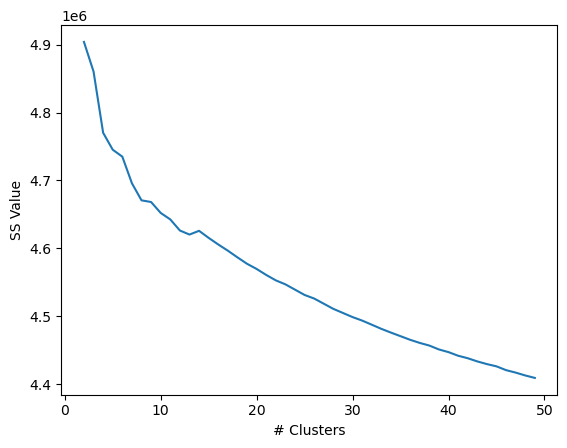

In [36]:
from sklearn.cluster import KMeans
import sklearn

SS_values = []
kk_values = range (2,50)

for num_clusters in kk_values:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(bem_df*1e43) # we are multiplying by 1e43
    SS_values.append(kmeans.inertia_)
    
ax = sns.lineplot(y=SS_values, x = kk_values);
ax.set(xlabel="# Clusters", ylabel = 'SS Value');

### We will select optimal value as 12 and perform the clustering again

In [37]:
num_clusters = 12

In [38]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(bem_df*1e43)
kmeans.labels_

array([3, 7, 2, ..., 6, 1, 1])

In [39]:
book_cluster = bookId_Map.assign(cluster_num = kmeans.labels_)

In [40]:
book_cluster.head(5)

Title  \
BookId                                                      
0                                Dr. Seuss: American Icon   
1                   Wonderful Worship in Smaller Churches   
2       Rising Sons and Daughters: Life Among Japan's ...   
3       Muslim Women's Choices: Religious Belief and S...   
4                             Dramatica for Screenwriters   

                                              description  \
BookId                                                      
0       Philip Nel takes a fascinating look into the k...   
1       This resource includes twelve principles in un...   
2       Wardell recalls his experience as a foreign st...   
3       Counters the Western views and stereotypes of ...   
4       Dramatica for Screenwriters by Armando Saldana...   

                            categories   Ratings  cluster_num  
BookId                                                         
0       ['Biography', 'Autobiography']  4.333333            3  
1                         ['Religion']  5.000000            7  
2                   ['Social Science']  4.000000            2  
3                         ['Religion']  2.000000           10  
4                        ['Reference']  5.000000            7

### Now we will use HuggingFace model to analyze the book personality based on the cluster assigned. The steps we will follow are as follows:

- Put together all the text from books in the same cluster
- Get personality of the cluster using HuggingFace library - https://huggingface.co/Minej/bert-base-personality
- Ask user to enter text to assess their personality
- Based on user personality identify the closest cluster by using cosine distance between personailty values
- Recommend top 5 books in the cluster that closely matches the user personality

#### Here is the function for getting user personality type using Hugging Face model

In [41]:
from transformers import BertTokenizer, BertForSequenceClassification

def personality_detection(text):
    tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
    model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result

#### Club text of the books in the same cluster together

In [42]:
cluster_text = []
for i in range (num_clusters):
    cluster_text.append(book_cluster[book_cluster.cluster_num == i].description.sum())


#### Get personality type from cluster text

In [43]:
cluster_personality_result = []
for x in range(len(cluster_text)):
    cluster_personality_result.append(personality_detection(cluster_text[x]))

#### Analyze the results

In [44]:
cluster_analysis_df = pd.DataFrame(cluster_personality_result)
cluster_analysis_df

Extroversion  Neuroticism  Agreeableness  Conscientiousness  Openness
0      -0.173596     0.077235       0.286539          -0.023153  0.277903
1      -0.180531     0.117402       0.223222           0.224351  0.240000
2      -0.425786     0.132827       0.258109          -0.240793 -0.039392
3      -0.140911     0.058348       0.229398          -0.372537  0.095843
4      -0.121187     0.223386       0.184633          -0.250837  0.142971
5      -0.151138     0.130494       0.266657          -0.144430  0.139426
6      -0.045484     0.023177       0.181009           0.030891  0.473379
7      -0.010821     0.055742       0.117074          -0.383787  0.175144
8      -0.041048     0.285837      -0.013113          -0.293762  0.328356
9       0.074150     0.212719       0.129479          -0.127371  0.419017
10      0.138024     0.149175       0.032978          -0.260281  0.275375
11      0.099326     0.170853       0.133756          -0.283091  0.326461

#### We will build a function to get book recommendations based on personality type

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
def getTop5BooksFromBio(text):
    print ("------------- Analysis Starts ------------")
    result = personality_detection(bio) #Get the personality value
    print (f"Your personality result {result}")
    dist = cosine_similarity(cluster_analysis_df, pd.DataFrame(result, index=[0])) #Calculate cosine similarity
    dist = np.absolute(dist)
    min_index = dist.argmin()
    print (f"Cosine distances between your personality and books personality are {dist} and the min index is {min_index}")
    print ("-------------  Analysis Ends ------------")
    
    #Get top 5 books from the cluster
    print ("")
    print ("-------------  Top 5 Books  ------------")
    print(book_cluster[book_cluster.cluster_num == min_index].sort_values(by="Ratings", ascending=False)[['Title']][0:5].to_string(index=False))
    
    

### A couple of example runs

#### Example 1

In [46]:
print ("Please share 3 - 4 lines about yourself")
bio = input()

Please share 3 - 4 lines about yourself
I like spending time alone and love to go into the nature. I love hiking and I practice yoga and meditation often


In [47]:
getTop5BooksFromBio (bio)

------------- Analysis Starts ------------
Your personality result {'Extroversion': 0.15667897, 'Neuroticism': 0.18387038, 'Agreeableness': -0.05196483, 'Conscientiousness': -0.48914763, 'Openness': 0.014780233}
Cosine distances between your personality and books personality are [[0.05132121]
 [0.5026083 ]
 [0.19675264]
 [0.61829454]
 [0.587009  ]
 [0.27747837]
 [0.07286479]
 [0.79656714]
 [0.6762401 ]
 [0.40297988]
 [0.75599277]
 [0.67744535]] and the min index is 0
-------------  Analysis Ends ------------

-------------  Top 5 Books  ------------
                                                                                                             Title
Vector Quantization and Signal Compression (The Springer International Series in Engineering and Computer Science)
                                                                          Not Ashamed: The Story of Jews for Jesus
                                                The Great Wall and the Empty Fortress: China's Sear

#### Example 2

In [48]:
print ("Please share 3 - 4 lines about yourself")
bio = input()

Please share 3 - 4 lines about yourself
I like to party. Meeting people and making new friends gives me energy.


In [49]:
getTop5BooksFromBio (bio)

------------- Analysis Starts ------------
Your personality result {'Extroversion': -0.05585039, 'Neuroticism': 0.06573107, 'Agreeableness': 0.037323017, 'Conscientiousness': -0.23692867, 'Openness': -0.10651664}
Cosine distances between your personality and books personality are [[0.01104617]
 [0.42133483]
 [0.65641785]
 [0.7522643 ]
 [0.6154939 ]
 [0.4312832 ]
 [0.33284745]
 [0.6634509 ]
 [0.37931606]
 [0.00155666]
 [0.2993672 ]
 [0.31514388]] and the min index is 9
-------------  Analysis Ends ------------

-------------  Top 5 Books  ------------
                                                                                                                                                       Title
                                                                                                                             History of Magic and the Occult
Your Disgusting Head: The Darkest, Most Offensive and Moist Secrets of Your Ears, Mouth and Nose (How Books: Haggis-On-Whey World

### We finally have a book recommendation model based on user personality type. Definitely, the model needs many improvements.